In [2]:
#!pip install scikit-learn

In [3]:
#!pip install geopandas

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from copy import deepcopy
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from ipywidgets import interact, fixed, IntSlider
from sklearn.metrics import pairwise_distances_argmin
import geopandas as gpd
# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

# Extracting Featureset and Dataset from City of Toronto Open Data

In [4]:
demograph_data = gpd.read_file('../Clean Data/demographic_data_clean_for_clustering.csv') 
#data = pd.read_csv('demographic_data_clean_for_clustering')
demograph_data.head(1000)

index       Category                                        Subcategory  \
0       0     Population                                        Total - Age   
1       1     Population                                        Total - Age   
2       2     Population                                        Total - Age   
3       3     Population                                        Total - Age   
4       4     Population                                        Total - Age   
..    ...            ...                                                ...   
995   995  Ethnocultural  Total - Ethnic or cultural origin for the popu...   
996   996  Ethnocultural  Total - Ethnic or cultural origin for the popu...   
997   997  Ethnocultural  Total - Ethnic or cultural origin for the popu...   
998   998  Ethnocultural  Total - Ethnic or cultural origin for the popu...   
999   999  Ethnocultural  Total - Ethnic or cultural origin for the popu...   

             Grouping  Toronto  Ward 1  Ward 2  Ward 3  Ward 4  Ward 5  ...  \
0         Total - Age  2761285  115120  117200  139920  104715  115675  ...   
1        0 to 4 years   123385    5755    5105    6765    4770    6045  ...   
2        5 to 9 years   128805    6160    5825    6180    5015    6060  ...   
3      10 to 14 years   131150    6585    6370    5515    5230    6360  ...   
4      15 to 19 years   133820    7085    6540    5160    4680    6390  ...   
..                ...      ...     ...     ...     ...     ...     ...  ...   
995      Cree, n.o.s.     1380      15      40      90     105      50  ...   
996            Korean    42200     500    1890    2365     835     375  ...   
997          Romanian    20010     280    1125    1080     835     210  ...   
998          Lebanese    11530     155     485     625     490     215  ...   
999           Iranian    37895     260     615    1165     425     175  ...   

    Ward 16 Ward 17 Ward 18 Ward 19 Ward 20 Ward 21 Ward 22 Ward 23 Ward 24  \
0     94335  112590  117130  108500  110095  111560  103690   94025  102755   
1      4600    4375    4525    6035    5610    5165    4000    3770    5195   
2      4755    4780    4480    6455    6230    5880    4480    4660    5890   
3      5225    5010    4425    6195    6285    5920    4815    4665    6090   
4      5225    5090    5035    5480    6425    6440    4930    4750    6030   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
995      10      15      15     150      75      50      40      10      50   
996    1380    4195   11050     815     505     525     790     225     285   
997    1480    1735    1015     870     490     385     285     155     355   
998     785     480     400     370     250    1135     465     115     195   
999    1800    6485   10370     615     490     475     645     185     305   

    Ward 25  
0    101485  
1      4365  
2      5080  
3      5590  
4      6105  
..      ...  
995      15  
996     300  
997     315  
998     300  
999     255  

[1000 rows x 30 columns]

# Perform Data Cleaning 

### Drop non-numerical columns and transpose the dataframe to define features

In [7]:
#Reset the index and turn the old index into a column before transposing
demograph_data = demograph_data.reset_index(drop = True)

#Drop disruptive columns
demograph_data = demograph_data.drop(columns=['index', 'Category', 'Subcategory'])

#Set the correct 'Grouping' column as the index
demograph_data = demograph_data.set_index('Grouping')

#Now transpose the DataFrame, which will make the rows into columns
demograph_data = demograph_data.T

#Drop the row for 'Toronto' after transposing 
tdemograph_data = demograph_data.drop(index=['Toronto'])

#Display the new DataFrame
tdemograph_data

Grouping Total - Age   0 to 4 years   5 to 9 years   10 to 14 years  \
Ward 1        115120           5755           6160             6585   
Ward 2        117200           5105           5825             6370   
Ward 3        139920           6765           6180             5515   
Ward 4        104715           4770           5015             5230   
Ward 5        115675           6045           6060             6360   
Ward 6        107355           5265           5205             5085   
Ward 7        111200           5785           6205             6780   
Ward 8        114820           5835           6205             7075   
Ward 9        104730           4665           4430             4005   
Ward 10       135400           4420           2765             2085   
Ward 11       102385           3130           2900             2950   
Ward 12       114095           4520           4345             4595   
Ward 13       116930           3720           3135             2455   
Ward 14       104555           5350           5775             5060   
Ward 15       101025           4615           5915             6770   
Ward 16        94335           4600           4755             5225   
Ward 17       112590           4375           4780             5010   
Ward 18       117130           4525           4480             4425   
Ward 19       108500           6035           6455             6195   
Ward 20       110095           5610           6230             6285   
Ward 21       111560           5165           5880             5920   
Ward 22       103690           4000           4480             4815   
Ward 23        94025           3770           4660             4665   
Ward 24       102755           5195           5890             6090   
Ward 25       101485           4365           5080             5590   

Grouping   15 to 19 years   20 to 24 years   25 to 29 years   30 to 34 years  \
Ward 1               7085             9645            10095             8125   
Ward 2               6540             6600             6820             6755   
Ward 3               5160             7040            11455            13980   
Ward 4               4680             4550             7690            10640   
Ward 5               6390             7490             8205             8450   
Ward 6               5705             7225             7840             7570   
Ward 7               7175             9380             8750             7460   
Ward 8               7220             7145             6975             7575   
Ward 9               3895             5595             9930            12345   
Ward 10              2195            10385            28800            27255   
Ward 11              3490             9715            13380            11965   
Ward 12              4485             5840            10945            12845   
Ward 13              3445            12140            17365            16335   
Ward 14              4200             4855             6620             9015   
Ward 15              6665             6035             5910             6495   
Ward 16              5225             5660             6735             6820   
Ward 17              5090             7610            10450             9870   
Ward 18              5035             8180            11500            11985   
Ward 19              5480             5295             6085             7760   
Ward 20              6425             7060             7285             7380   
Ward 21              6440             8155             8935             8055   
Ward 22              4930             6715             7605             7025   
Ward 23              4750             6835             7150             6595   
Ward 24              6030             7820             8560             7245   
Ward 25              6105             7585             7540             6140   

Grouping   35 to 39 years   40 to 44 years  ...  \
Ward 1               

In [8]:
pd.set_option('display.max_columns', None)

demograph_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26 entries, Toronto to Ward 25
Columns: 1482 entries, Total - Age to     Other government transfers %
dtypes: object(1482)
memory usage: 302.3+ KB


In [9]:
type(demograph_data)

pandas.core.frame.DataFrame

### Find all column names, then sift through to find most relevant 

In [11]:
column_names = demograph_data.columns.tolist()
print(column_names)
#remember to remove the spaces in the column names

['Total - Age', '  0 to 4 years', '  5 to 9 years', '  10 to 14 years', '  15 to 19 years', '  20 to 24 years', '  25 to 29 years', '  30 to 34 years', '  35 to 39 years', '  40 to 44 years', '  45 to 49 years', '  50 to 54 years', '  55 to 59 years', '  60 to 64 years', '  65 to 69 years', '  70 to 74 years', '  75 to 79 years', '  80 to 84 years', '  85 to 89 years', '  90 years and over', 'Median age', 'Total - Occupied private dwellings by structural type of dwelling - 25% sample data', '  Single-detached house', '  Semi-detached house', '  Row house', '  Apartment or flat in a duplex', '  Apartment in a building that has fewer than five storeys', '  Apartment in a building that has five or more storeys', '  Other single-attached house', '  Movable dwelling', 'Total - Tenure (includes band housing)', '  Owned', '    Part of a condominium', '    Not part of a condominium', '  Rented', '    Part of a condominium', '    Not part of a condominium', 'Total - Occupied private dwellings b

In [12]:
#Check data types
tdemograph_data.dtypes

Grouping
Total - Age                                                                    object
  0 to 4 years                                                                 object
  5 to 9 years                                                                 object
  10 to 14 years                                                               object
  15 to 19 years                                                               object
                                                                                ...  
    Canada Pension Plan (CPP) and QuÃšbec Pension Plan (QPP) benefits %        object
    Old Age Security pension (OAS) and Guaranteed Income Supplement (GIS) %    object
    Employment Insurance (EI) benefits %                                       object
    Child benefits $                                                           object
    Other government transfers %                                               object
Length: 1482, dtype: object

In [13]:
#Further debugging step to look at where issues lied in data in a csv
#tdemograph_data.to_csv('C:/Users/amirv/OneDrive/Desktop/bigproject/transposed_data.csv', index=False)

In [14]:
tdemograph_data.head(25) 

Grouping Total - Age   0 to 4 years   5 to 9 years   10 to 14 years  \
Ward 1        115120           5755           6160             6585   
Ward 2        117200           5105           5825             6370   
Ward 3        139920           6765           6180             5515   
Ward 4        104715           4770           5015             5230   
Ward 5        115675           6045           6060             6360   
Ward 6        107355           5265           5205             5085   
Ward 7        111200           5785           6205             6780   
Ward 8        114820           5835           6205             7075   
Ward 9        104730           4665           4430             4005   
Ward 10       135400           4420           2765             2085   
Ward 11       102385           3130           2900             2950   
Ward 12       114095           4520           4345             4595   
Ward 13       116930           3720           3135             2455   
Ward 14       104555           5350           5775             5060   
Ward 15       101025           4615           5915             6770   
Ward 16        94335           4600           4755             5225   
Ward 17       112590           4375           4780             5010   
Ward 18       117130           4525           4480             4425   
Ward 19       108500           6035           6455             6195   
Ward 20       110095           5610           6230             6285   
Ward 21       111560           5165           5880             5920   
Ward 22       103690           4000           4480             4815   
Ward 23        94025           3770           4660             4665   
Ward 24       102755           5195           5890             6090   
Ward 25       101485           4365           5080             5590   

Grouping   15 to 19 years   20 to 24 years   25 to 29 years   30 to 34 years  \
Ward 1               7085             9645            10095             8125   
Ward 2               6540             6600             6820             6755   
Ward 3               5160             7040            11455            13980   
Ward 4               4680             4550             7690            10640   
Ward 5               6390             7490             8205             8450   
Ward 6               5705             7225             7840             7570   
Ward 7               7175             9380             8750             7460   
Ward 8               7220             7145             6975             7575   
Ward 9               3895             5595             9930            12345   
Ward 10              2195            10385            28800            27255   
Ward 11              3490             9715            13380            11965   
Ward 12              4485             5840            10945            12845   
Ward 13              3445            12140            17365            16335   
Ward 14              4200             4855             6620             9015   
Ward 15              6665             6035             5910             6495   
Ward 16              5225             5660             6735             6820   
Ward 17              5090             7610            10450             9870   
Ward 18              5035             8180            11500            11985   
Ward 19              5480             5295             6085             7760   
Ward 20              6425             7060             7285             7380   
Ward 21              6440             8155             8935             8055   
Ward 22              4930             6715             7605             7025   
Ward 23              4750             6835             7150             6595   
Ward 24              6030             7820             8560             7245   
Ward 25              6105             7585             7540             6140   

Grouping   35 to 39 years   40 to 44 years   45 to 49 years   50 to 54 y

In [45]:
#Converts values to numeric as there are columns with non-numeric values still 
tdemograph_data = tdemograph_data.apply(pd.to_numeric, errors='coerce')

print(tdemograph_data)

Grouping  Total - Age    0 to 4 years    5 to 9 years    10 to 14 years  \
Ward 1         115120            5755            6160              6585   
Ward 2         117200            5105            5825              6370   
Ward 3         139920            6765            6180              5515   
Ward 4         104715            4770            5015              5230   
Ward 5         115675            6045            6060              6360   
Ward 6         107355            5265            5205              5085   
Ward 7         111200            5785            6205              6780   
Ward 8         114820            5835            6205              7075   
Ward 9         104730            4665            4430              4005   
Ward 10        135400            4420            2765              2085   
Ward 11        102385            3130            2900              2950   
Ward 12        114095            4520            4345              4595   
Ward 13        116930    

In [46]:
#Fill empty values with 0
tdemograph_data.fillna(0)

#Drop columns with NaN values
tdemograph_data_clean = tdemograph_data.dropna(axis = 1, how = 'any')

tdemograph_data_clean.columns = tdemograph_data_clean.columns.str.strip()
print(tdemograph_data_clean.dtypes)

tdemograph_data_clean.head()


Grouping
Total - Age                                                                  int64
0 to 4 years                                                                 int64
5 to 9 years                                                                 int64
10 to 14 years                                                               int64
15 to 19 years                                                               int64
                                                                            ...   
Canada Pension Plan (CPP) and QuÃšbec Pension Plan (QPP) benefits %        float64
Old Age Security pension (OAS) and Guaranteed Income Supplement (GIS) %    float64
Employment Insurance (EI) benefits %                                       float64
Child benefits $                                                           float64
Other government transfers %                                               float64
Length: 1471, dtype: object


Grouping  Total - Age  0 to 4 years  5 to 9 years  10 to 14 years  \
Ward 1         115120          5755          6160            6585   
Ward 2         117200          5105          5825            6370   
Ward 3         139920          6765          6180            5515   
Ward 4         104715          4770          5015            5230   
Ward 5         115675          6045          6060            6360   

Grouping  15 to 19 years  20 to 24 years  25 to 29 years  30 to 34 years  \
Ward 1              7085            9645           10095            8125   
Ward 2              6540            6600            6820            6755   
Ward 3              5160            7040           11455           13980   
Ward 4              4680            4550            7690           10640   
Ward 5              6390            7490            8205            8450   

Grouping  35 to 39 years  40 to 44 years  45 to 49 years  50 to 54 years  \
Ward 1              7265            6905            7035            7515   
Ward 2              7395            7045            7135            8380   
Ward 3             12460           10305            9380            9215   
Ward 4              9900            8465            7925            7345   
Ward 5              8400            7845            7325            7970   

Grouping  55 to 59 years  60 to 64 years  65 to 69 years  70 to 74 years  \
Ward 1              7925            7070            5495            4745   
Ward 2              9530            8675            7165            6020   
Ward 3              9705            9140            7315            6365   
Ward 4              7010            6260            5100            4230   
Ward 5              8875            7860            5900            4470   

Grouping  75 to 79 years  80 to 84 years  85 to 89 years  90 years and over  \
Ward 1              3140            2390            1435                745   
Ward 2              4060            3575            2555               1650   
Ward 3              4065            3000            1830               1045   
Ward 4              2500            1715            1105                575   
Ward 5              3035            2295            1665               1035   

Grouping  Median age  \
Ward 1          38.0   
Ward 2          45.2   
Ward 3          40.8   
Ward 4          40.0   
Ward 5          40.4   

Grouping  Total - Occupied private dwellings by structural type of dwelling - 25% sample data  \
Ward 1                                                38135                                     
Ward 2                                                45345                                     
Ward 3                                                65575                                     
Ward 4                                                49445                                     
Ward 5                                                45055                                     

Grouping  Single-detached house  Semi-detached house  Row house  \
Ward 1                    11270                 1425       3645   
Ward 2                    21860                  875       2005   
Ward 3                    18585                 1365       2340   
Ward 4                     8855                 4215       1175   
Ward 5                    13190                 3315       1265   

Grouping  Apartment or flat in a duplex  \
Ward 1                             3790   
Ward 2                              785   
Ward 3                             1500   
Ward 4                             2120   
Ward 5                             1845   

Grouping  Apartment in a building that has fewer than five storeys  \
Ward 1                                                 2015          
Ward 2                                                 1925          
Ward 3                                                11100          
Ward 4                                                14040          

In [47]:
selected_columns = ['15 to 19 years', '20 to 24 years', '25 to 29 years', '30 to 34 years', 
                    '35 to 39 years', '40 to 44 years', '45 to 49 years', '50 to 54 years', 
                    '55 to 59 years', '60 to 64 years', '65 to 69 years', '70 to 74 years', 
                    '75 to 79 years', '80 to 84 years', '85 to 89 years', '90 years and over', 
                    '1960 or before', '1961 to 1980', '1981 to 1990', '1991 to 2000', '2001 to 2005', 
                    '2006 to 2010', '2011 to 2015', '2016 to 2021', 'Non-immigrants', 'Immigrants', 
                    'Official languages', 'Non-official languages', 'No certificate, diploma or degree', 
                    'High (secondary) school diploma or equivalency certificate', 
                    'Postsecondary certificate, diploma or degree',  'Employed', 'Unemployed', 
                    'Not in the labour force', 'Under $5,000', '$5,000 to $9,999', '$10,000 to $14,999', 
                    '$15,000 to $19,999', '$20,000 to $24,999', '$25,000 to $29,999', '$30,000 to $34,999', 
                    '$35,000 to $39,999', '$40,000 to $44,999', '$45,000 to $49,999', '$50,000 to $59,999', 
                    '$60,000 to $69,999', '$70,000 to $79,999', '$80,000 to $89,999', '$90,000 to $99,999', 
                    '$100,000 to $124,999', '$125,000 to $149,999', '$150,000 to $199,999', '$200,000 and over', 
                    'Average total income of households in 2020 ($)', 
                    'Average monthly shelter costs for owned dwellings ($)', 
                    'Average total income in 2020 among recipients ($)', 
                    '% of owner households spending 30% or more of its income on shelter costs']

tdemograph_data_clean = tdemograph_data_clean[selected_columns] 

In [51]:
tdemograph_data_clean #whys is there a row called level_0?

Grouping  15 to 19 years  20 to 24 years  25 to 29 years  30 to 34 years  \
Ward 1              7085            9645           10095            8125   
Ward 2              6540            6600            6820            6755   
Ward 3              5160            7040           11455           13980   
Ward 4              4680            4550            7690           10640   
Ward 5              6390            7490            8205            8450   
Ward 6              5705            7225            7840            7570   
Ward 7              7175            9380            8750            7460   
Ward 8              7220            7145            6975            7575   
Ward 9              3895            5595            9930           12345   
Ward 10             2195           10385           28800           27255   
Ward 11             3490            9715           13380           11965   
Ward 12             4485            5840           10945           12845   
Ward 13             3445           12140           17365           16335   
Ward 14             4200            4855            6620            9015   
Ward 15             6665            6035            5910            6495   
Ward 16             5225            5660            6735            6820   
Ward 17             5090            7610           10450            9870   
Ward 18             5035            8180           11500           11985   
Ward 19             5480            5295            6085            7760   
Ward 20             6425            7060            7285            7380   
Ward 21             6440            8155            8935            8055   
Ward 22             4930            6715            7605            7025   
Ward 23             4750            6835            7150            6595   
Ward 24             6030            7820            8560            7245   
Ward 25             6105            7585            7540            6140   

Grouping  35 to 39 years  40 to 44 years  45 to 49 years  50 to 54 years  \
Ward 1              7265            6905            7035            7515   
Ward 2              7395            7045            7135            8380   
Ward 3             12460           10305            9380            9215   
Ward 4              9900            8465            7925            7345   
Ward 5              8400            7845            7325            7970   
Ward 6              7560            7710            7305            7515   
Ward 7              7445            7180            6605            7685   
Ward 8              7580            7910            7955            8195   
Ward 9             10760            8415            7045            6660   
Ward 10            15870            9345            6630            5580   
Ward 11             8315            5805            5405            5805   
Ward 12            10070            7505            7130            6970   
Ward 13            11390            7635            6535            6850   
Ward 14             9515            8915            7935            7405   
Ward 15             6380            6565            7075            7895   
Ward 16             6280            6250            6095            6470   
Ward 17             8405            6975            6740            7265   
Ward 18             9520            7880            7455            7660   
Ward 19             8765            8915            8010            8140   
Ward 20             7645            7500            7370            8010   
Ward 21             7455            6685            6905            7490   
Ward 22             6305            5655            6010            6955   
Ward 23             5645            5185            5350            6475   
Ward 24             6535            6410            6200            6765   
Ward 25             5980            5660            6200            6640   

Grouping  55 to 59 years  60 to 64 years  65 t

In [53]:
tdemograph_data_clean = tdemograph_data_clean.loc[:, ~tdemograph_data_clean.columns.duplicated()]

In [55]:
tdemograph_data_clean

Grouping  15 to 19 years  20 to 24 years  25 to 29 years  30 to 34 years  \
Ward 1              7085            9645           10095            8125   
Ward 2              6540            6600            6820            6755   
Ward 3              5160            7040           11455           13980   
Ward 4              4680            4550            7690           10640   
Ward 5              6390            7490            8205            8450   
Ward 6              5705            7225            7840            7570   
Ward 7              7175            9380            8750            7460   
Ward 8              7220            7145            6975            7575   
Ward 9              3895            5595            9930           12345   
Ward 10             2195           10385           28800           27255   
Ward 11             3490            9715           13380           11965   
Ward 12             4485            5840           10945           12845   
Ward 13             3445           12140           17365           16335   
Ward 14             4200            4855            6620            9015   
Ward 15             6665            6035            5910            6495   
Ward 16             5225            5660            6735            6820   
Ward 17             5090            7610           10450            9870   
Ward 18             5035            8180           11500           11985   
Ward 19             5480            5295            6085            7760   
Ward 20             6425            7060            7285            7380   
Ward 21             6440            8155            8935            8055   
Ward 22             4930            6715            7605            7025   
Ward 23             4750            6835            7150            6595   
Ward 24             6030            7820            8560            7245   
Ward 25             6105            7585            7540            6140   

Grouping  35 to 39 years  40 to 44 years  45 to 49 years  50 to 54 years  \
Ward 1              7265            6905            7035            7515   
Ward 2              7395            7045            7135            8380   
Ward 3             12460           10305            9380            9215   
Ward 4              9900            8465            7925            7345   
Ward 5              8400            7845            7325            7970   
Ward 6              7560            7710            7305            7515   
Ward 7              7445            7180            6605            7685   
Ward 8              7580            7910            7955            8195   
Ward 9             10760            8415            7045            6660   
Ward 10            15870            9345            6630            5580   
Ward 11             8315            5805            5405            5805   
Ward 12            10070            7505            7130            6970   
Ward 13            11390            7635            6535            6850   
Ward 14             9515            8915            7935            7405   
Ward 15             6380            6565            7075            7895   
Ward 16             6280            6250            6095            6470   
Ward 17             8405            6975            6740            7265   
Ward 18             9520            7880            7455            7660   
Ward 19             8765            8915            8010            8140   
Ward 20             7645            7500            7370            8010   
Ward 21             7455            6685            6905            7490   
Ward 22             6305            5655            6010            6955   
Ward 23             5645            5185            5350            6475   
Ward 24             6535            6410            6200            6765   
Ward 25             5980            5660            6200            6640   

Grouping  55 to 59 years  60 to 64 years  65 t

In [57]:
#Import collision data to use in conjunction with demographic data

collision_data = gpd.read_file('../Clean Data/collision_ward_data.geojson') 
#do strip for column labels 
#do .describe()
collision_data.head()

DATE  HOUR DAY OF WEEK  MONTH  YEAR BICYCLE  LONGITUDE   LATITUDE  \
0 2014-01-02    18    Thursday      1  2014     YES -79.380272  43.648644   
1 2014-01-03    11      Friday      1  2014     YES -79.399845  43.652539   
2 2014-01-09    13    Thursday      1  2014     YES -79.405167  43.656966   
3 2014-01-09     5    Thursday      1  2014     YES -79.480613  43.665578   
4 2014-01-12    22      Sunday      1  2014     YES -79.377892  43.649143   

                TIME OF DAY WARD NUMBER            WARD NAME  \
0     Evening (5 PM - 9 PM)          13       Toronto Centre   
1    Morning (5 AM - 12 PM)          10    Spadina-Fort York   
2  Afternoon (12 PM - 5 PM)          11  University-Rosedale   
3    Morning (5 AM - 12 PM)          04   Parkdale-High Park   
4       Night (9 PM - 5 AM)          13       Toronto Centre   

           WARD DISTRICT                    geometry  
0  Toronto and East York  POINT (-79.38027 43.64864)  
1  Toronto and East York  POINT (-79.39984 43.65254)  
2  Toronto and East York  POINT (-79.40517 43.65697)  
3  Toronto and East York  POINT (-79.48061 43.66558)  
4  Toronto and East York  POINT (-79.37789 43.64914)

In [58]:
collision_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 10402 entries, 0 to 10401
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   DATE           10402 non-null  datetime64[ms]
 1   HOUR           10402 non-null  int32         
 2   DAY OF WEEK    10402 non-null  object        
 3   MONTH          10402 non-null  int32         
 4   YEAR           10402 non-null  int32         
 5   BICYCLE        10402 non-null  object        
 6   LONGITUDE      10402 non-null  float64       
 7   LATITUDE       10402 non-null  float64       
 8   TIME OF DAY    10402 non-null  object        
 9   WARD NUMBER    10375 non-null  object        
 10  WARD NAME      10375 non-null  object        
 11  WARD DISTRICT  10375 non-null  object        
 12  geometry       10402 non-null  geometry      
dtypes: datetime64[ms](1), float64(2), geometry(1), int32(3), object(6)
memory usage: 934.7+ KB


In [61]:
#Perform further data cleaning
collision_data['BICYCLE'] = collision_data['BICYCLE'].str.lower()
collision_data['BICYCLE'] = collision_data['BICYCLE'].map({'yes': 1, 'no': 0})
bike_collision = collision_data[collision_data['BICYCLE'] == 1]
ward_collision = (bike_collision.groupby('WARD NUMBER', as_index = False).agg(
                                        {'BICYCLE': 'sum',               #Total number of collisions for a ward
                                         'LATITUDE': 'mean',             #Average latitude (future use)
                                         'LONGITUDE': 'mean',            #Average longitude (future use)
                                         'WARD NAME': 'first'            # Ward name
                  }).rename(columns={'BICYCLE': 'Bike Collisions', 'WARD NUMBER': 'Ward #', 'LATITUDE': 'Avg Latitude', 'LONGITUDE': 'Avg Longitude', 'WARD NAME': 'Ward Name'}))

cols = list(ward_collision.columns)
#Rearrange the columns for clarity 
cols.remove('Ward Name')  #Remove 'Ward Name' temporarily
cols.insert(cols.index('Ward #') + 1, 'Ward Name')
ward_collision = ward_collision[cols]
ward_collision

Ward #                 Ward Name  Bike Collisions  Avg Latitude  \
0      01           Etobicoke North              216     43.727229   
1      02          Etobicoke Centre              217     43.667718   
2      03       Etobicoke-Lakeshore              376     43.620498   
3      04        Parkdale-High Park              550     43.650676   
4      05         York South-Weston              268     43.689563   
5      06               York Centre              242     43.751176   
6      07  Humber River-Black Creek              176     43.750481   
7      08         Eglinton-Lawrence              228     43.713493   
8      09                 Davenport              741     43.662404   
9      10         Spadina-Fort York             1587     43.645822   
10     11       University-Rosedale             1324     43.664261   
11     12        Toronto-St. Paul's              364     43.687308   
12     13            Toronto Centre             1132     43.658768   
13     14          Toronto-Danforth              716     43.671276   
14     15           Don Valley West              198     43.717832   
15     16           Don Valley East               96     43.733581   
16     17          Don Valley North              129     43.782411   
17     18                Willowdale              173     43.777330   
18     19         Beaches-East York              353     43.684734   
19     20     Scarborough Southwest              262     43.712957   
20     21        Scarborough Centre              277     43.749344   
21     22     Scarborough-Agincourt              242     43.798298   
22     23         Scarborough North              219     43.808651   
23     24     Scarborough-Guildwood              143     43.767247   
24     25    Scarborough-Rouge Park              146     43.791461   

    Avg Longitude  
0      -79.583182  
1      -79.550024  
2      -79.514390  
3      -79.458589  
4      -79.489267  
5      -79.473017  
6      -79.522831  
7      -79.432990  
8      -79.439988  
9      -79.397764  
10     -79.401827  
11     -79.412727  
12     -79.374637  
13     -79.342229  
14     -79.374766  
15     -79.335149  
16     -79.358126  
17     -79.418684  
18     -79.307466  
19     -79.267564  
20     -79.280575  
21     -79.307229  
22     -79.268227  
23     -79.219518  
24     -79.182070

In [140]:
ward_collision.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Ward #           25 non-null     int32  
 1   Ward Name        25 non-null     object 
 2   Bike Collisions  25 non-null     int64  
 3   Avg Latitude     25 non-null     float64
 4   Avg Longitude    25 non-null     float64
dtypes: float64(2), int32(1), int64(1), object(1)
memory usage: 1.0+ KB


In [63]:
#Combining or binning data to get better descriptors of data that follow traditional socioeconomic categories of lower, middle, and higher classes

tdemograph_data_clean['20 to 29 years'] = (
    tdemograph_data_clean.pop('20 to 24 years') +
    tdemograph_data_clean.pop('25 to 29 years')
)

tdemograph_data_clean['30 to 49 years'] = (
    tdemograph_data_clean.pop('30 to 34 years') +
    tdemograph_data_clean.pop('35 to 39 years') +
    tdemograph_data_clean.pop('40 to 44 years') +
    tdemograph_data_clean.pop('45 to 49 years')
)

tdemograph_data_clean['50 to 69 years'] = (
    tdemograph_data_clean.pop('50 to 54 years') +
    tdemograph_data_clean.pop('55 to 59 years') +
    tdemograph_data_clean.pop('60 to 64 years') +
    tdemograph_data_clean.pop('65 to 69 years')
)

tdemograph_data_clean['70 years and over'] = (
    tdemograph_data_clean.pop('70 to 74 years') +
    tdemograph_data_clean.pop('75 to 79 years') +
    tdemograph_data_clean.pop('80 to 84 years') +
    tdemograph_data_clean.pop('85 to 89 years') +
    tdemograph_data_clean.pop('90 years and over')
)

tdemograph_data_clean['Constructed from 2000 or before'] = (
    tdemograph_data_clean.pop('1960 or before') +
    tdemograph_data_clean.pop('1961 to 1980') +
    tdemograph_data_clean.pop('1981 to 1990') +
    tdemograph_data_clean.pop('1991 to 2000')
)

tdemograph_data_clean['Constructed from 2000 or after'] = (
    tdemograph_data_clean.pop('2001 to 2005') +
    tdemograph_data_clean.pop('2006 to 2010') +
    tdemograph_data_clean.pop('2011 to 2015') +
    tdemograph_data_clean.pop('2016 to 2021')
)

#Poverty level of household income 

tdemograph_data_clean['$10,000 or lower Total Income'] = (
    tdemograph_data_clean.pop('Under $5,000') +
    tdemograph_data_clean.pop('$5,000 to $9,999')
)
#Above poverty line to $35000 (minimum wage)
tdemograph_data_clean['$10,000 to $34,999'] = (
    tdemograph_data_clean.pop('$10,000 to $14,999') +
    tdemograph_data_clean.pop('$15,000 to $19,999') +
    tdemograph_data_clean.pop('$20,000 to $24,999') +
    tdemograph_data_clean.pop('$25,000 to $29,999') +
    tdemograph_data_clean.pop('$30,000 to $34,999')
)
#From minimum wage to $50,000, lower class
tdemograph_data_clean['$35,000 to $69,999'] = (
    tdemograph_data_clean.pop('$35,000 to $39,999') +
    tdemograph_data_clean.pop('$40,000 to $44,999') +
    tdemograph_data_clean.pop('$45,000 to $49,999') +
    tdemograph_data_clean.pop('$50,000 to $59,999') +
    tdemograph_data_clean.pop('$60,000 to $69,999')
)

#Middle class
tdemograph_data_clean['$70,000 to $149,999'] = (
    tdemograph_data_clean.pop('$70,000 to $79,999') +
    tdemograph_data_clean.pop('$80,000 to $89,999') +
    tdemograph_data_clean.pop('$90,000 to $99,999') +
    tdemograph_data_clean.pop('$100,000 to $124,999') +
    tdemograph_data_clean.pop('$125,000 to $149,999') + 
    tdemograph_data_clean.pop('$150,000 to $199,999')
)
#High class is $200,000 and over

#Rearrange the columns for clarity 
cols = list(tdemograph_data_clean.columns)
cols.remove('15 to 19 years')  #Remove temporarily
cols.insert(cols.index('% of owner households spending 30% or more of its income on shelter costs') + 1, '15 to 19 years')
tdemograph_data_clean = tdemograph_data_clean[cols]

In [65]:
tdemograph_data_clean.head(26)

Grouping  Non-immigrants  Immigrants  Official languages  \
Ward 1             43640       64675               52375   
Ward 2             66315       48485               63190   
Ward 3             80045       54670               80715   
Ward 4             69575       32400               70615   
Ward 5             52820       58205               57935   
Ward 6             43790       59525               46060   
Ward 7             40905       62700               49125   
Ward 8             65435       44725               68855   
Ward 9             60865       39645               59015   
Ward 10            70400       53910               77435   
Ward 11            59515       34755               63545   
Ward 12            67205       40430               73390   
Ward 13            56170       48730               62305   
Ward 14            70475       31915               71060   
Ward 15            55720       41420               56320   
Ward 16            39635       50390               42660   
Ward 17            34110       68280               35750   
Ward 18            35140       70535               35345   
Ward 19            71210       34420               75370   
Ward 20            55395       50370               60385   
Ward 21            43560       61670               48180   
Ward 22            31595       66065               32160   
Ward 23            28855       60740               28220   
Ward 24            42060       54840               49910   
Ward 25            45475       52660               56460   

Grouping  Non-official languages  No certificate, diploma or degree  \
Ward 1                     53515                              21870   
Ward 2                     47635                              12955   
Ward 3                     51185                              12970   
Ward 4                     29135                               9500   
Ward 5                     50610                              25160   
Ward 6                     53505                              14700   
Ward 7                     53325                              25665   
Ward 8                     39440                              12045   
Ward 9                     39750                              18865   
Ward 10                    48260                               6555   
Ward 11                    33615                               7245   
Ward 12                    34810                               8230   
Ward 13                    45720                               8330   
Ward 14                    28810                              12495   
Ward 15                    38815                               8135   
Ward 16                    43920                              11670   
Ward 17                    67815                               9570   
Ward 18                    73615                               7865   
Ward 19                    27470                              11445   
Ward 20                    41920                              15480   
Ward 21                    54220                              16805   
Ward 22                    64045                              16795   
Ward 23                    58950                              17555   
Ward 24                    44605                              14775   
Ward 25                    37970                              12825   

Grouping  High (secondary) school diploma or equivalency certificate  \
Ward 1                                                28780            
Ward 2                                                25030            
Ward 3                                                25415            
Ward 4                                                17360            
Ward 5                                                29000            
Ward 6                                                23755            
Ward 7                                                28780            
Ward 8          

In [67]:
#Debugging cell 
tdemograph_data_clean = tdemograph_data_clean.select_dtypes(include=np.number)

if tdemograph_data_clean.isnull().values.any():
    tdemograph_data_clean = tdemograph_data_clean.fillna(0)

In [69]:
#Applying min max scaling to control feature influence
from sklearn.preprocessing import MinMaxScaler

#Initialize MinMaxScaler
scaler = MinMaxScaler()

#Apply scaling to columns 

tdemograph_data_clean_scaled = pd.DataFrame(scaler.fit_transform(tdemograph_data_clean), 
                               columns = tdemograph_data_clean.columns)

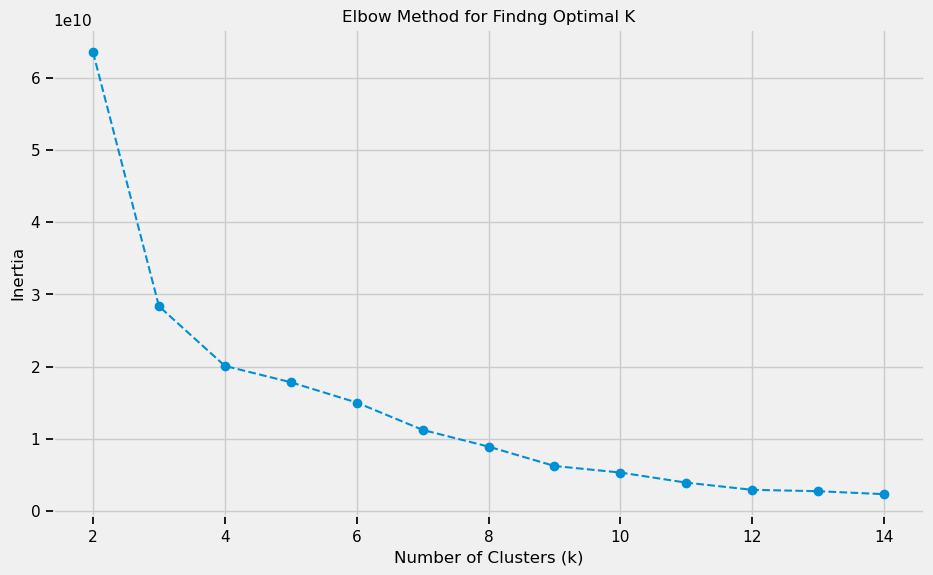

In [71]:
#Use the Elbow method to find number of clusters needed
inertia = []
k_range = range(2, 15)  #Test for different number of clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tdemograph_data_clean)
    inertia.append(kmeans.inertia_)

#Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.title("Elbow Method for Findng Optimal K")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.show()

In [72]:
tdemograph_data_clean_scaled.head(26)

Grouping  Non-immigrants  Immigrants  Official languages  \
0               0.288826    0.848265            0.460139   
1               0.731784    0.429052            0.666159   
2               1.000000    0.589202            1.000000   
3               0.795468    0.012558            0.807601   
4               0.468158    0.680735            0.566054   
5               0.291756    0.714915            0.339842   
6               0.235398    0.797126            0.398228   
7               0.714593    0.331693            0.774074   
8               0.625317    0.200155            0.586627   
9               0.811584    0.569524            0.937518   
10              0.598945    0.073537            0.672921   
11              0.749170    0.220482            0.860463   
12              0.533600    0.435396            0.649300   
13              0.813049    0.000000            0.816078   
14              0.524810    0.246116            0.535289   
15              0.210588    0.478379            0.275074   
16              0.102657    0.941611            0.143442   
17              0.122778    1.000000            0.135727   
18              0.827408    0.064863            0.898181   
19              0.518461    0.477861            0.612725   
20              0.287263    0.770456            0.380227   
21              0.053526    0.884257            0.075055   
22              0.000000    0.746375            0.000000   
23              0.257961    0.593604            0.413182   
24              0.324673    0.537157            0.537956   

Grouping  Non-official languages  No certificate, diploma or degree  \
0                       0.564417                           0.801413   
1                       0.436992                           0.334903   
2                       0.513924                           0.335688   
3                       0.036082                           0.154108   
4                       0.501463                           0.973574   
5                       0.564200                           0.426217   
6                       0.560299                           1.000000   
7                       0.259400                           0.287284   
8                       0.266118                           0.644165   
9                       0.450536                           0.000000   
10                      0.133167                           0.036107   
11                      0.159064                           0.087650   
12                      0.395492                           0.092883   
13                      0.029039                           0.310832   
14                      0.245855                           0.082679   
15                      0.356485                           0.267661   
16                      0.874309                           0.157771   
17                      1.000000                           0.068550   
18                      0.000000                           0.255887   
19                      0.313143                           0.467033   
20                      0.579694                           0.536368   
21                      0.792610                           0.535845   
22                      0.682197                           0.575615   
23                      0.371330                           0.430141   
24                      0.227544                           0.328100   

Grouping  High (secondary) school diploma or equivalency certificate  \
0                                                  0.983018            
1                                                  0.693555            
2                                                  0.723273            
3                                                  0.101505            
4                                                  1.000000            
5                                                  0.595137            
6                                                  0.983018            
7               

Text(0.5, 1.0, 'Correlation Matrix of Features')

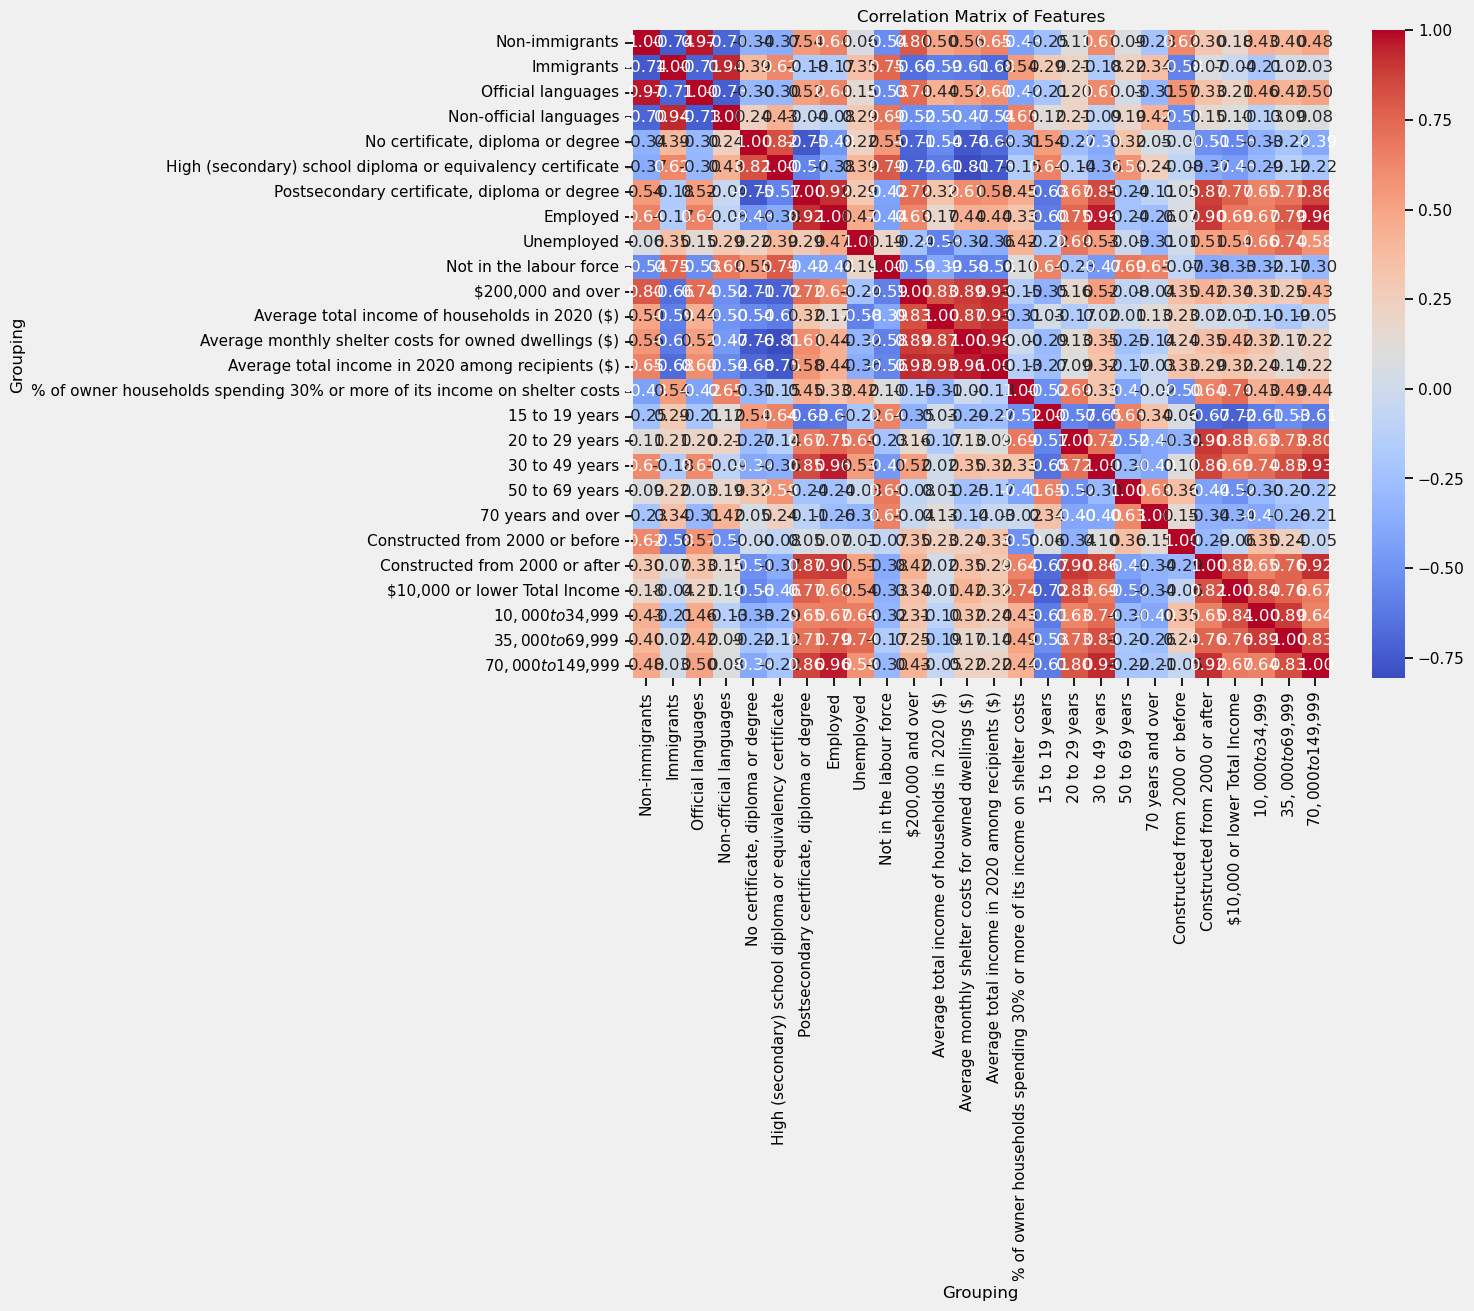

In [73]:
correlation_matrix = tdemograph_data_clean_scaled.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Features")

In [147]:
#Choose an optimal number of clusters based on the Elbow Curve
optimal_k = 5  # Adjust based on the elbow curve
kmeans = KMeans(n_clusters = optimal_k, random_state = 42, n_init = 100)
tdemograph_data_clean_scaled['Cluster'] = kmeans.fit_predict(tdemograph_data_clean_scaled)
tdemograph_data_clean_scaled['Cluster'] = tdemograph_data_clean_scaled['Cluster'].astype(int)


In [148]:
#curse of dimensionality
#might need to split up the dataframe but how should i do that 
#becuz at a certain point, the distance between points in let's say a 30 dimensional space becomes meaningless 

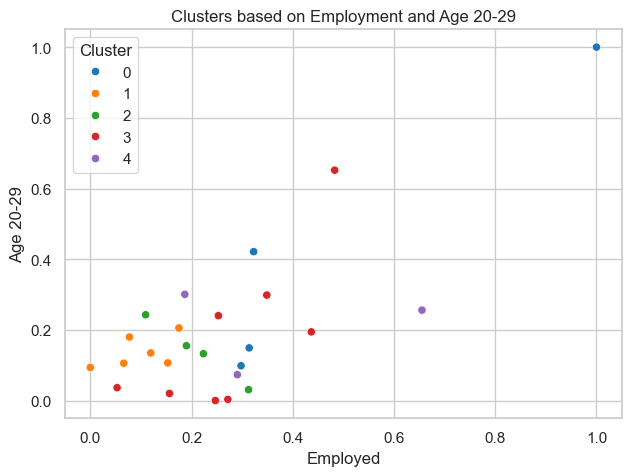

In [149]:
#Use only numeric columns 
num_cols = tdemograph_data_clean.select_dtypes(include=np.number).columns.tolist()
num_cols = [col for col in num_cols if col != 'Cluster']

#Visualize clusters with a plot, using 'Cluster' for hue

tdemograph_data_clean = tdemograph_data.dropna(axis=1, how='any') #THIS CAUSES ERROR EVEN IF I PUT AXIS = 1 FOR COLUMN

# sns.scatterplot(tdemograph_data_clean, hue='Cluster', palette='blue') 
# plt.title("Cluster Plot")
# plt.show()

tdemograph_data_clean_scaled['Cluster'] = kmeans.labels_
tdemograph_data_clean_scaled['Cluster'] = tdemograph_data_clean_scaled['Cluster'].astype("category")
# Plot scatterplot with a defined x and y 
sns.scatterplot(
    data = tdemograph_data_clean_scaled, 
    x = 'Employed', 
    y = '20 to 29 years', 
    hue = 'Cluster', 
    palette = 'tab10'
)
plt.title("Clusters based on Employment and Age 20-29")
plt.xlabel("Employed")
plt.ylabel("Age 20-29")
plt.legend(title="Cluster", loc='best')
plt.show()

In [153]:
tdemograph_data_clean_scaled

Grouping  Non-immigrants  Immigrants  Official languages  \
0               0.288826    0.848265            0.460139   
1               0.731784    0.429052            0.666159   
2               1.000000    0.589202            1.000000   
3               0.795468    0.012558            0.807601   
4               0.468158    0.680735            0.566054   
5               0.291756    0.714915            0.339842   
6               0.235398    0.797126            0.398228   
7               0.714593    0.331693            0.774074   
8               0.625317    0.200155            0.586627   
9               0.811584    0.569524            0.937518   
10              0.598945    0.073537            0.672921   
11              0.749170    0.220482            0.860463   
12              0.533600    0.435396            0.649300   
13              0.813049    0.000000            0.816078   
14              0.524810    0.246116            0.535289   
15              0.210588    0.478379            0.275074   
16              0.102657    0.941611            0.143442   
17              0.122778    1.000000            0.135727   
18              0.827408    0.064863            0.898181   
19              0.518461    0.477861            0.612725   
20              0.287263    0.770456            0.380227   
21              0.053526    0.884257            0.075055   
22              0.000000    0.746375            0.000000   
23              0.257961    0.593604            0.413182   
24              0.324673    0.537157            0.537956   

Grouping  Non-official languages  No certificate, diploma or degree  \
0                       0.564417                           0.801413   
1                       0.436992                           0.334903   
2                       0.513924                           0.335688   
3                       0.036082                           0.154108   
4                       0.501463                           0.973574   
5                       0.564200                           0.426217   
6                       0.560299                           1.000000   
7                       0.259400                           0.287284   
8                       0.266118                           0.644165   
9                       0.450536                           0.000000   
10                      0.133167                           0.036107   
11                      0.159064                           0.087650   
12                      0.395492                           0.092883   
13                      0.029039                           0.310832   
14                      0.245855                           0.082679   
15                      0.356485                           0.267661   
16                      0.874309                           0.157771   
17                      1.000000                           0.068550   
18                      0.000000                           0.255887   
19                      0.313143                           0.467033   
20                      0.579694                           0.536368   
21                      0.792610                           0.535845   
22                      0.682197                           0.575615   
23                      0.371330                           0.430141   
24                      0.227544                           0.328100   

Grouping  High (secondary) school diploma or equivalency certificate  \
0                                                  0.983018            
1                                                  0.693555            
2                                                  0.723273            
3                                                  0.101505            
4                                                  1.000000            
5                                                  0.595137            
6                                                  0.983018            
7               

In [155]:
tdemograph_data_clean_scaled.groupby('Cluster').mean()

Grouping  Non-immigrants  Immigrants  Official languages  \
Cluster                                                    
0               0.687610    0.293727            0.742785   
1               0.240314    0.668285            0.336524   
2               0.447695    0.551334            0.527931   
3               0.485507    0.423356            0.539194   
4               0.673536    0.622173            0.708766   

Grouping  Non-official languages  No certificate, diploma or degree  \
Cluster                                                               
0                       0.277305                           0.241889   
1                       0.494420                           0.478851   
2                       0.415511                           0.638475   
3                       0.382531                           0.165489   
4                       0.505111                           0.490668   

Grouping  High (secondary) school diploma or equivalency certificate  \
Cluster                                                                
0                                                  0.187476            
1                                                  0.690081            
2                                                  0.669915            
3                                                  0.244162            
4                                                  0.799949            

Grouping  Postsecondary certificate, diploma or degree  Employed  Unemployed  \
Cluster                                                                        
0                                             0.528478  0.483585    0.420000   
1                                             0.149452  0.098462    0.386167   
2                                             0.175500  0.208823    0.489500   
3                                             0.420130  0.281132    0.347375   
4                                             0.398030  0.377478    0.533667   

Grouping  Not in the labour force  $200,000 and over  \
Cluster                                                
0                        0.301841           0.809450   
1                        0.759986           0.135633   
2                        0.638092           0.279725   
3                        0.518903           0.587493   
4                        0.872019           0.559918   

Grouping  Average total income of households in 2020 ($)  \
Cluster                                                    
0                                               0.420381   
1                                               0.104242   
2                                               0.119159   
3                                               0.324227   
4                                               0.268152   

Grouping  Average monthly shelter costs for owned dwellings ($)  \
Cluster                                                           
0                                                  0.505572       
1                                                  0.081971       
2                                                  0.184250       
3                                                  0.456352       
4                                                  0.207033       

Grouping  Average total income in 2020 among recipients ($)  \
Cluster                                                       
0                                                  0.580769   
1                                                  0.080758   
2                                                  0.179675   
3                                                  0.439268   
4                                                  0.298324   

Grouping  % of owner households spending 30% or more of its income on shelter costs  \
Cluster                                                                               
0                                                  0.439433                           
1                           

In [157]:
tdemograph_data_clean_scaled.head(26)

Grouping  Non-immigrants  Immigrants  Official languages  \
0               0.288826    0.848265            0.460139   
1               0.731784    0.429052            0.666159   
2               1.000000    0.589202            1.000000   
3               0.795468    0.012558            0.807601   
4               0.468158    0.680735            0.566054   
5               0.291756    0.714915            0.339842   
6               0.235398    0.797126            0.398228   
7               0.714593    0.331693            0.774074   
8               0.625317    0.200155            0.586627   
9               0.811584    0.569524            0.937518   
10              0.598945    0.073537            0.672921   
11              0.749170    0.220482            0.860463   
12              0.533600    0.435396            0.649300   
13              0.813049    0.000000            0.816078   
14              0.524810    0.246116            0.535289   
15              0.210588    0.478379            0.275074   
16              0.102657    0.941611            0.143442   
17              0.122778    1.000000            0.135727   
18              0.827408    0.064863            0.898181   
19              0.518461    0.477861            0.612725   
20              0.287263    0.770456            0.380227   
21              0.053526    0.884257            0.075055   
22              0.000000    0.746375            0.000000   
23              0.257961    0.593604            0.413182   
24              0.324673    0.537157            0.537956   

Grouping  Non-official languages  No certificate, diploma or degree  \
0                       0.564417                           0.801413   
1                       0.436992                           0.334903   
2                       0.513924                           0.335688   
3                       0.036082                           0.154108   
4                       0.501463                           0.973574   
5                       0.564200                           0.426217   
6                       0.560299                           1.000000   
7                       0.259400                           0.287284   
8                       0.266118                           0.644165   
9                       0.450536                           0.000000   
10                      0.133167                           0.036107   
11                      0.159064                           0.087650   
12                      0.395492                           0.092883   
13                      0.029039                           0.310832   
14                      0.245855                           0.082679   
15                      0.356485                           0.267661   
16                      0.874309                           0.157771   
17                      1.000000                           0.068550   
18                      0.000000                           0.255887   
19                      0.313143                           0.467033   
20                      0.579694                           0.536368   
21                      0.792610                           0.535845   
22                      0.682197                           0.575615   
23                      0.371330                           0.430141   
24                      0.227544                           0.328100   

Grouping  High (secondary) school diploma or equivalency certificate  \
0                                                  0.983018            
1                                                  0.693555            
2                                                  0.723273            
3                                                  0.101505            
4                                                  1.000000            
5                                                  0.595137            
6                                                  0.983018            
7               

<Figure size 1200x800 with 0 Axes>

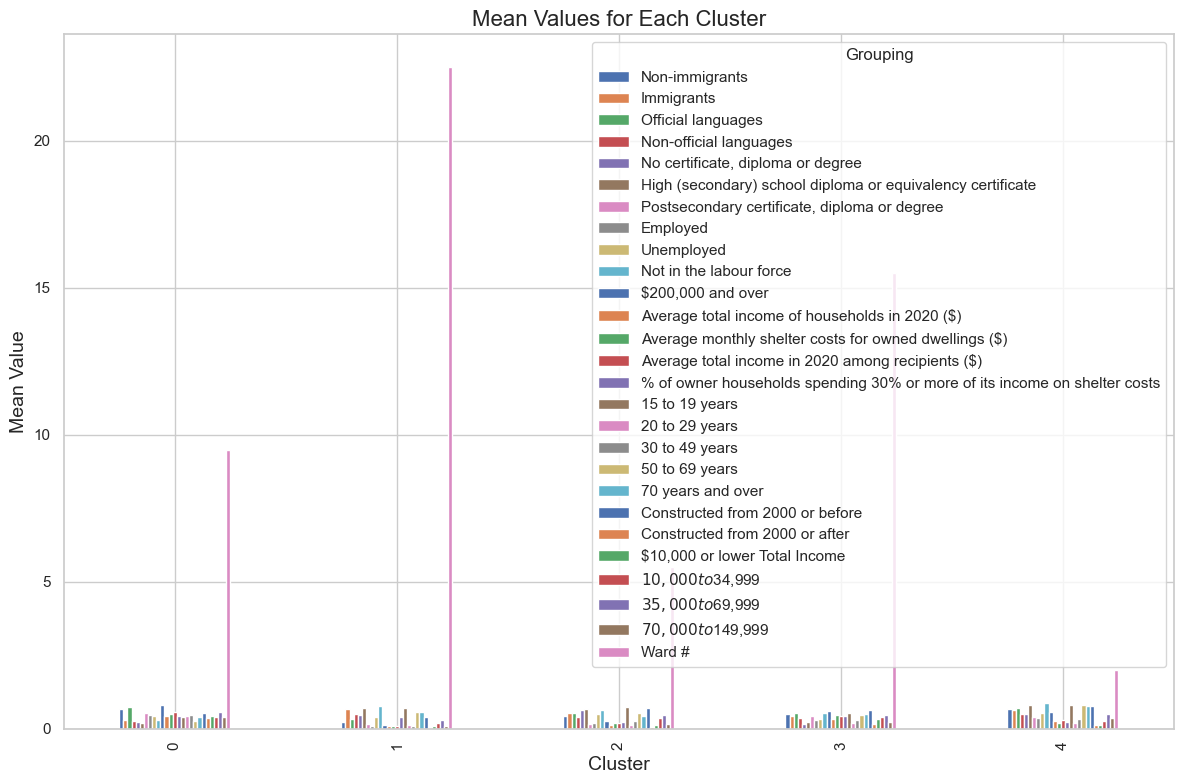

In [159]:
cluster_means = tdemograph_data_clean_scaled.groupby('Cluster').mean()
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Plot the means for each column in the DataFrame
cluster_means.plot(kind='bar', figsize=(12, 8))

# Set title and labels
plt.title('Mean Values for Each Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Mean Value', fontsize=14)

# Display the plot
plt.tight_layout()
plt.show()

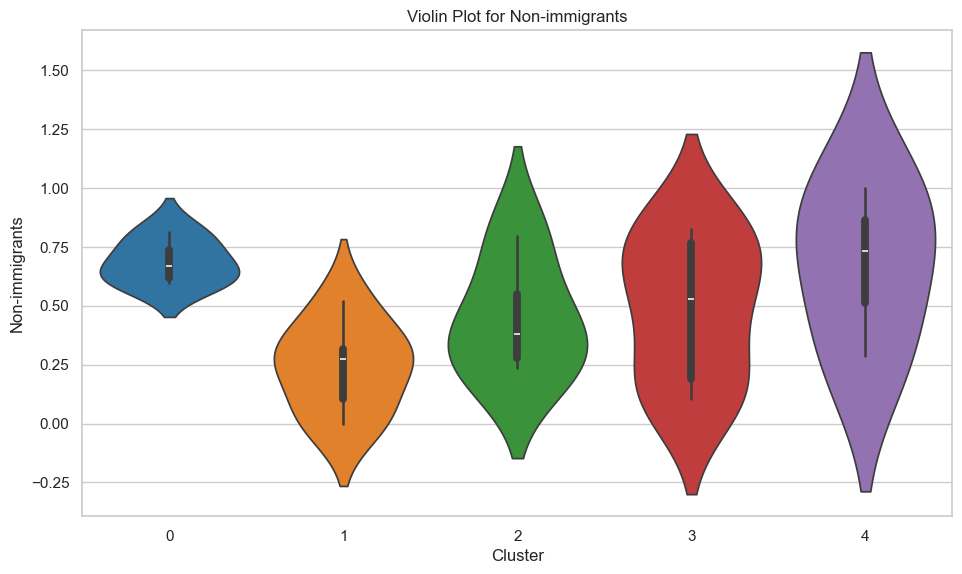

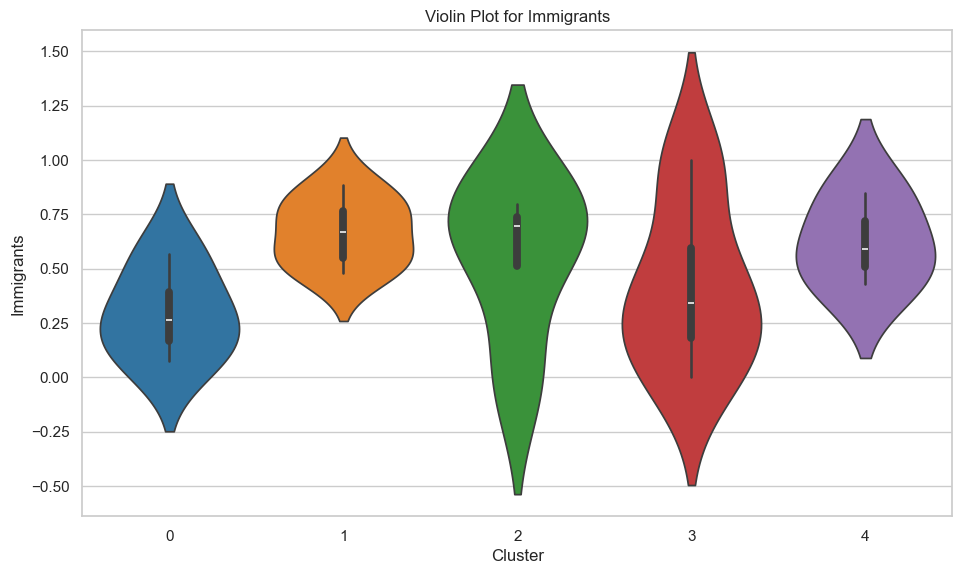

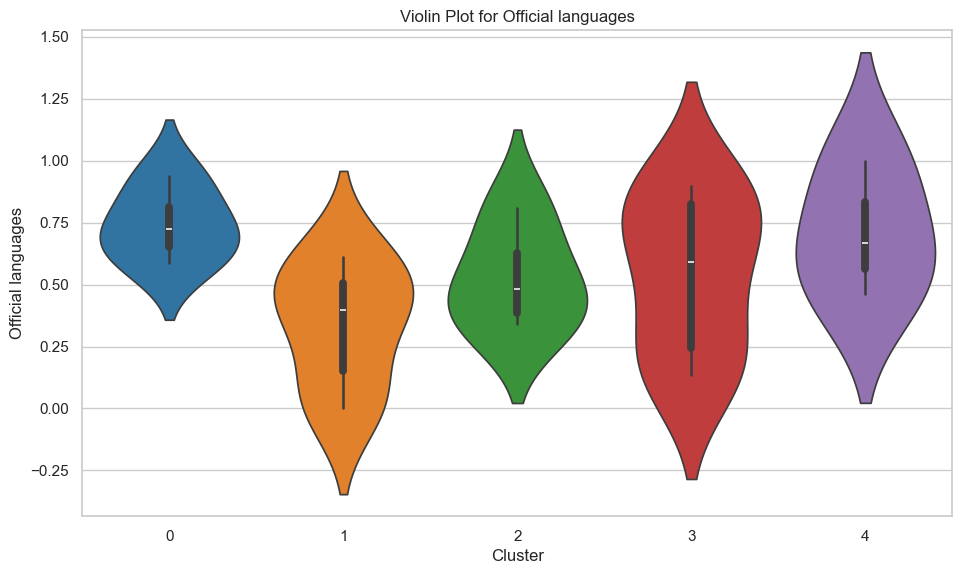

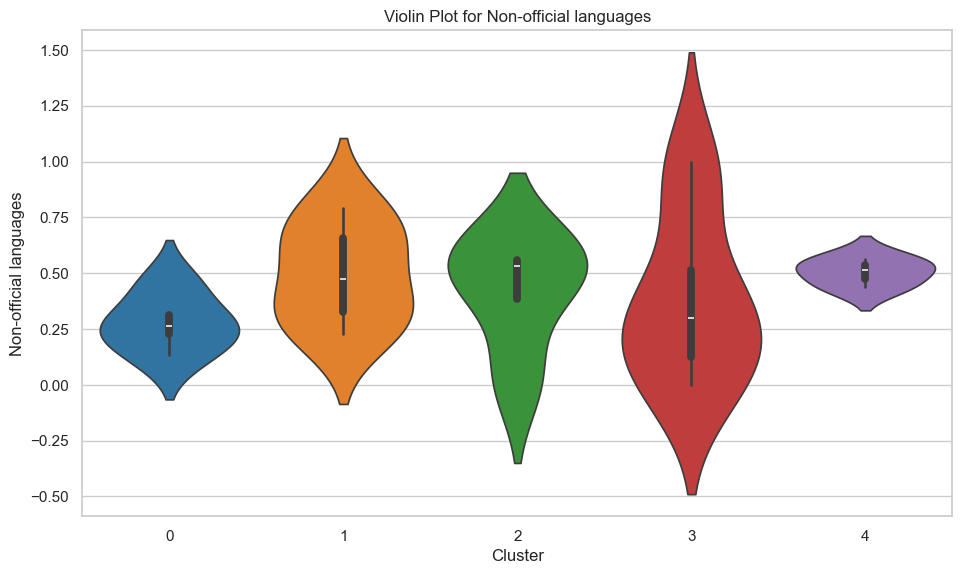

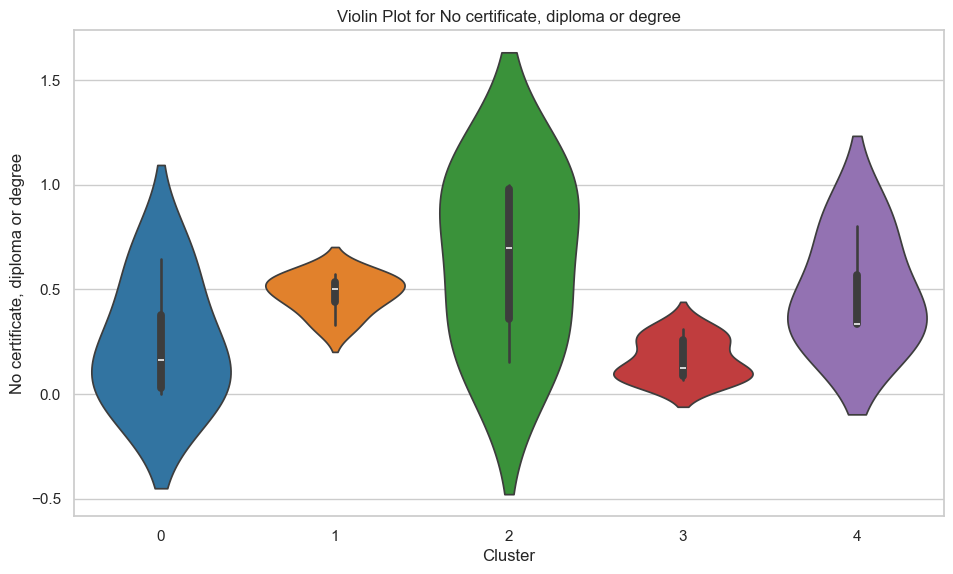

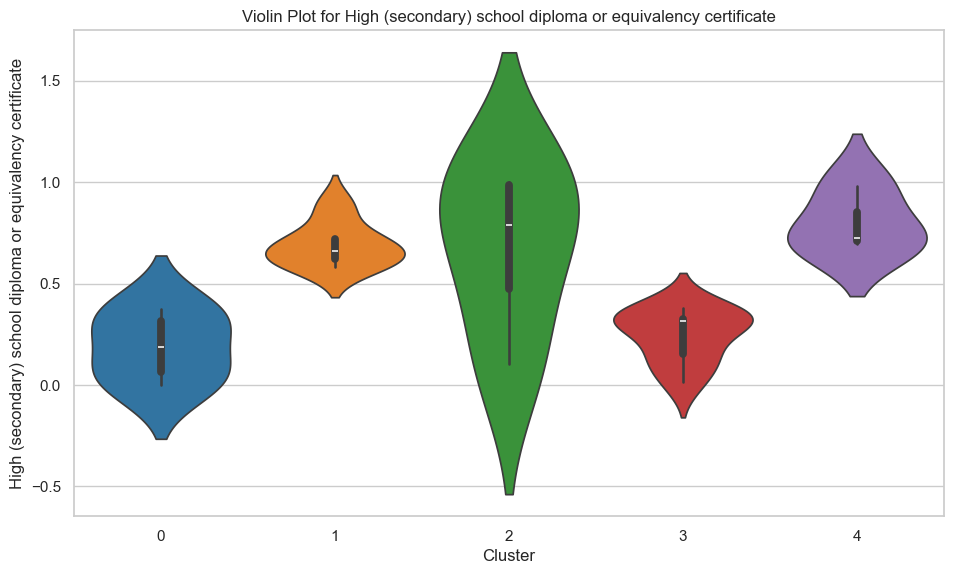

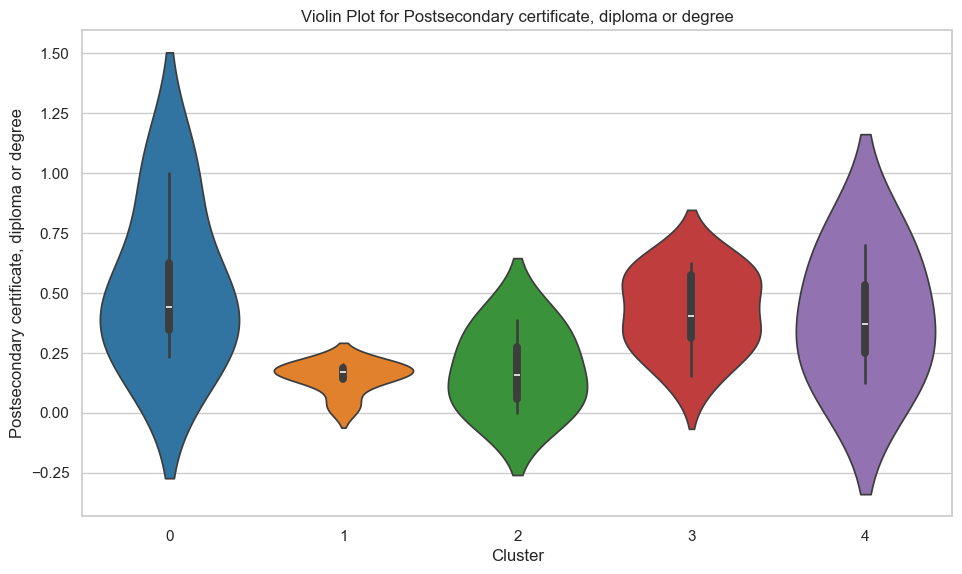

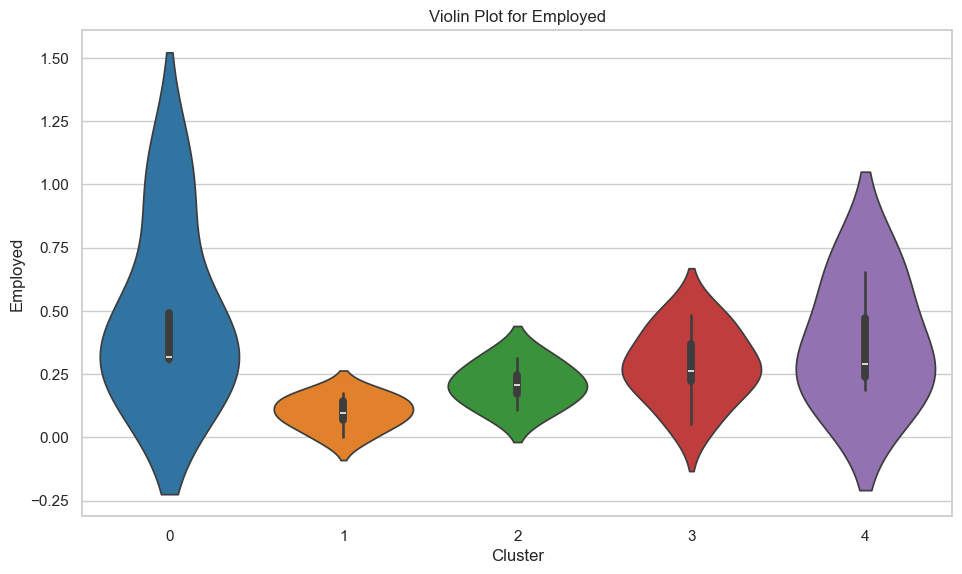

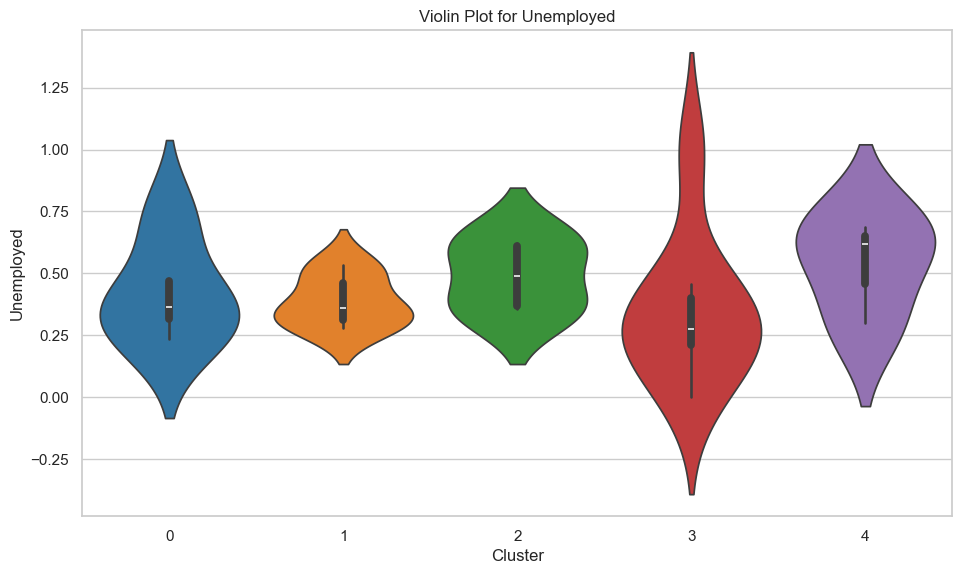

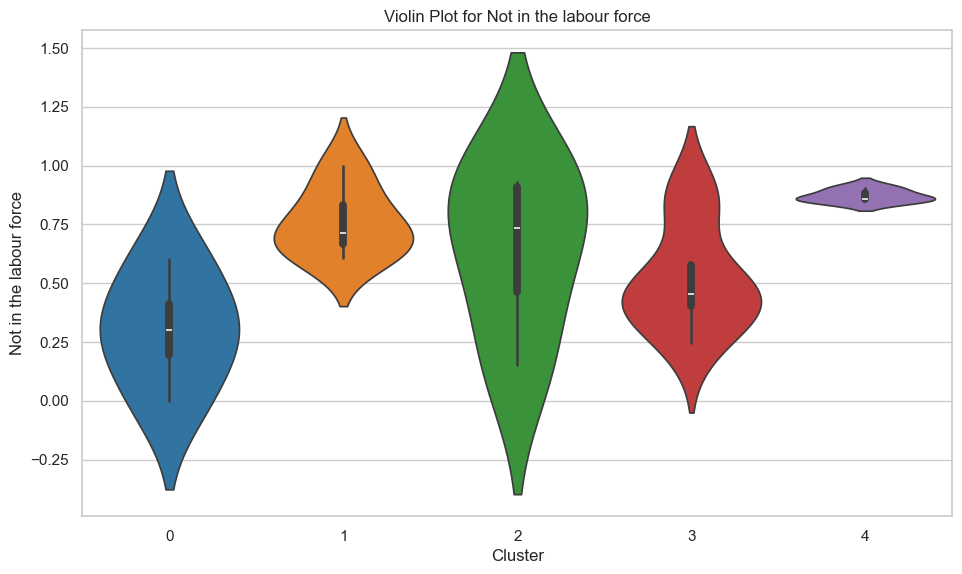

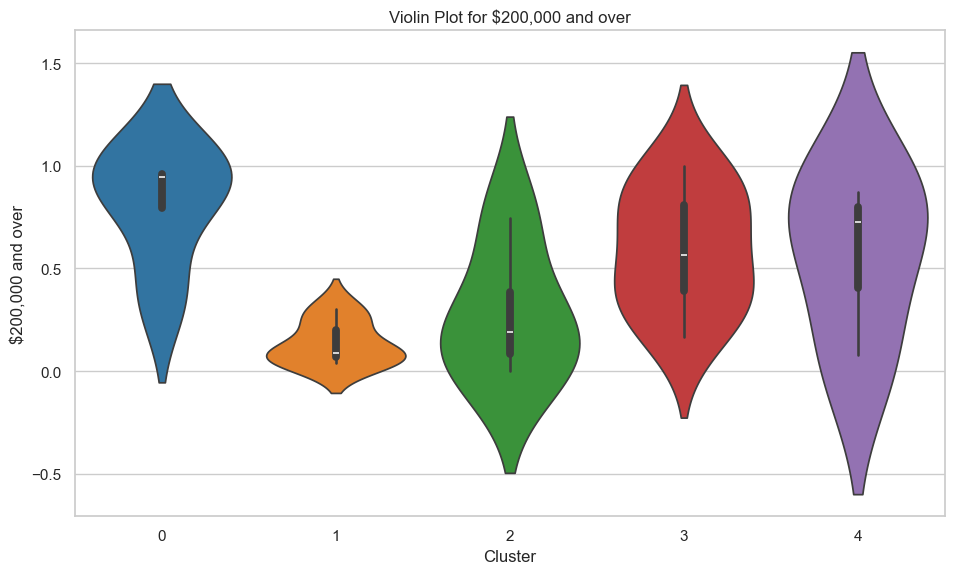

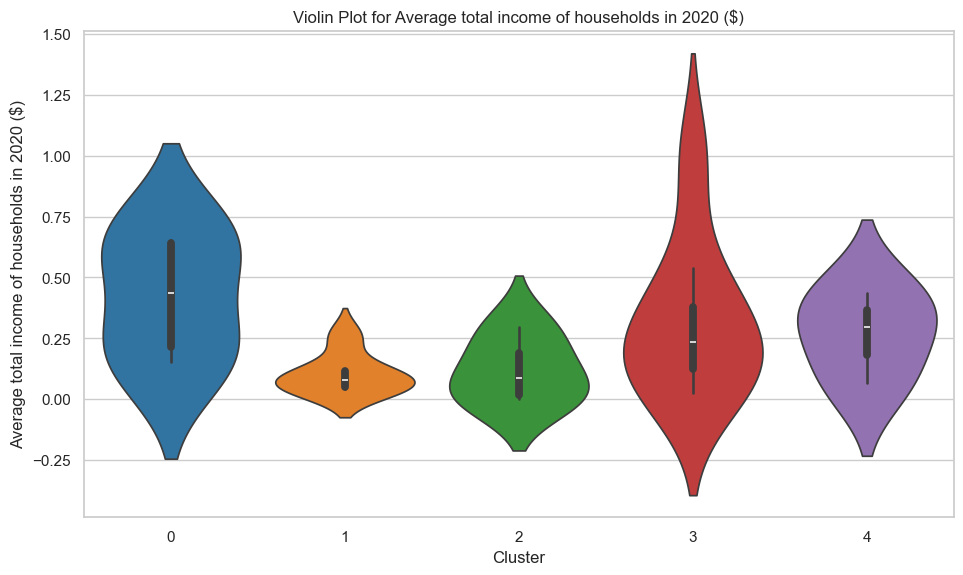

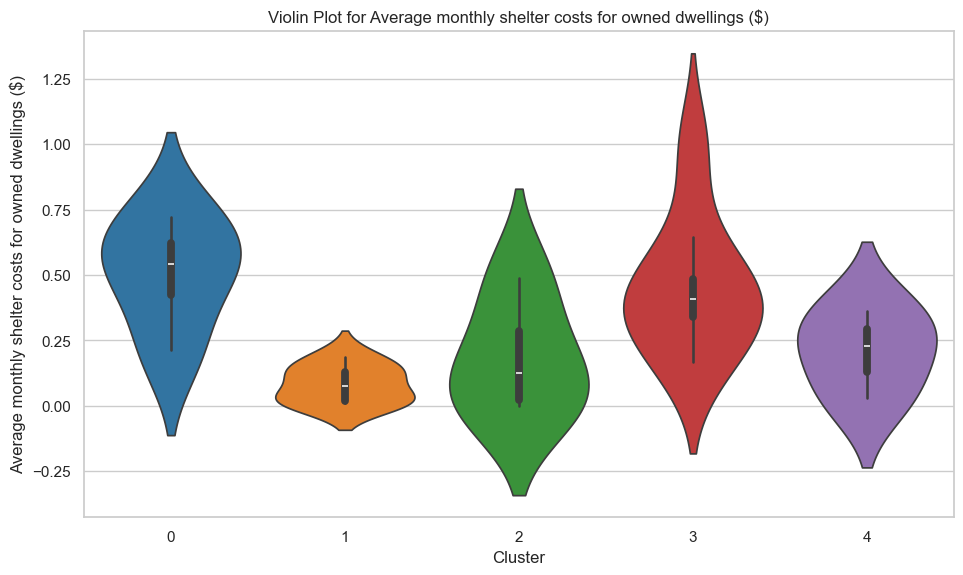

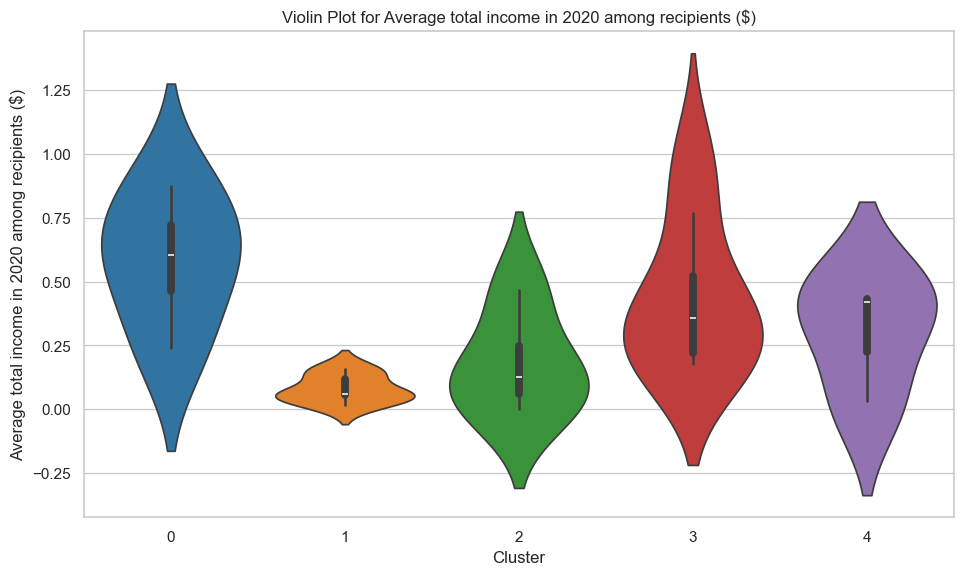

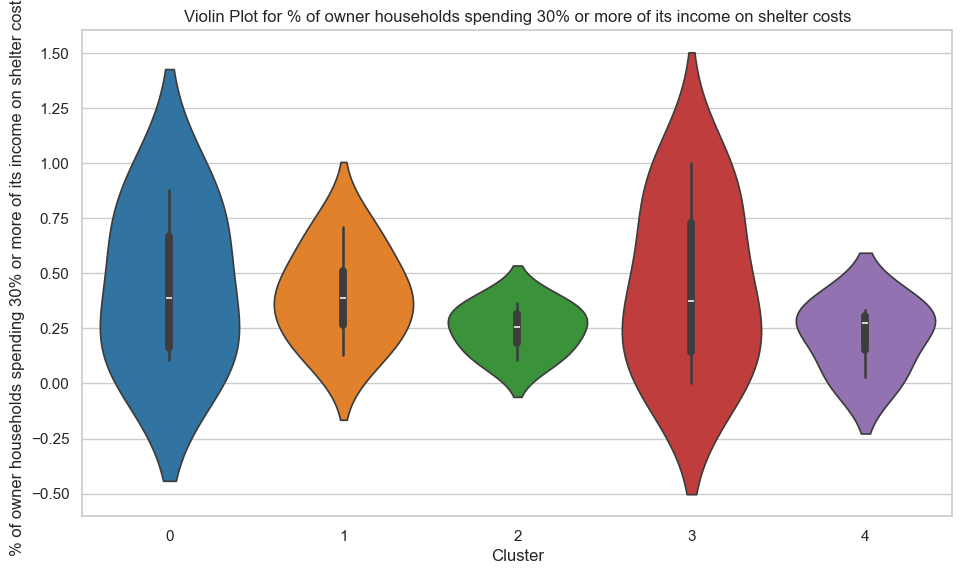

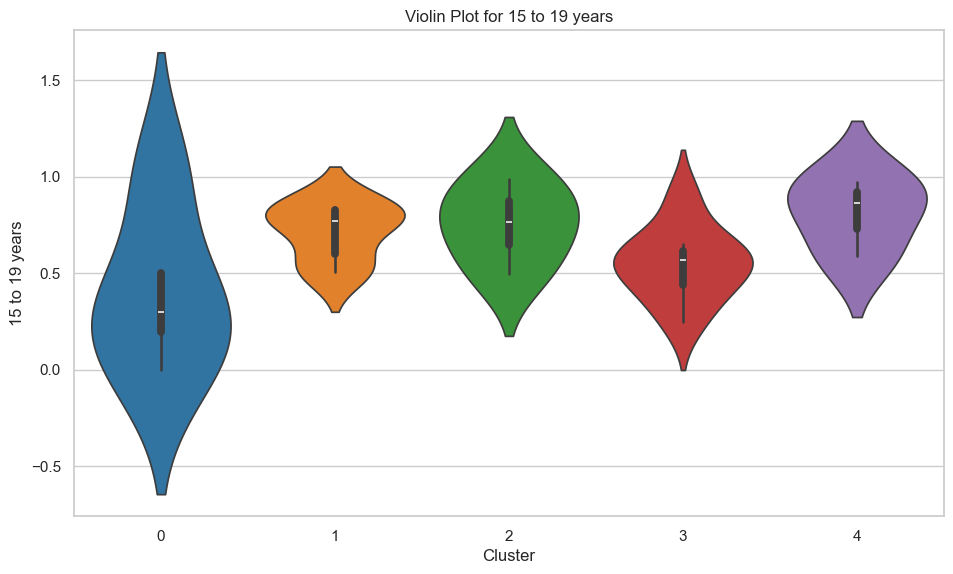

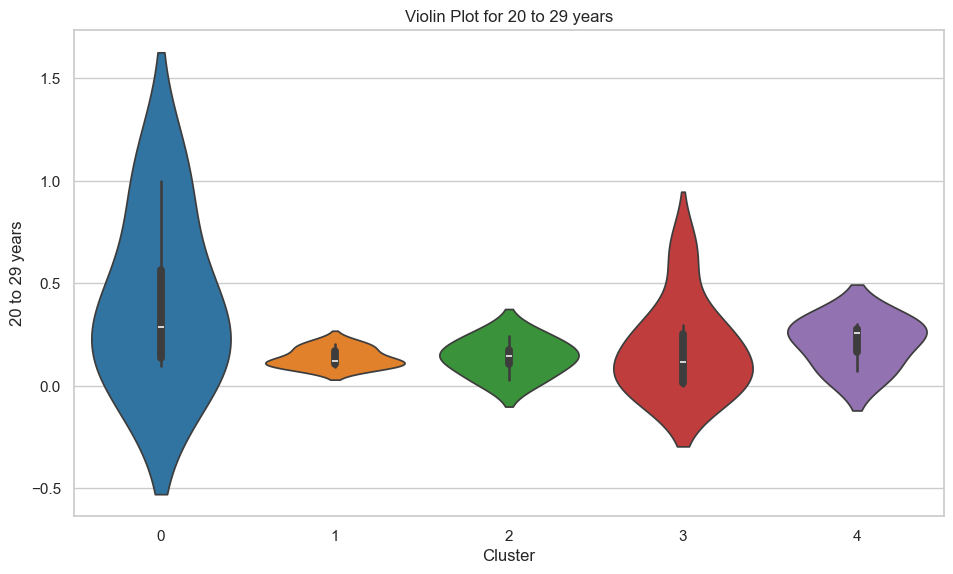

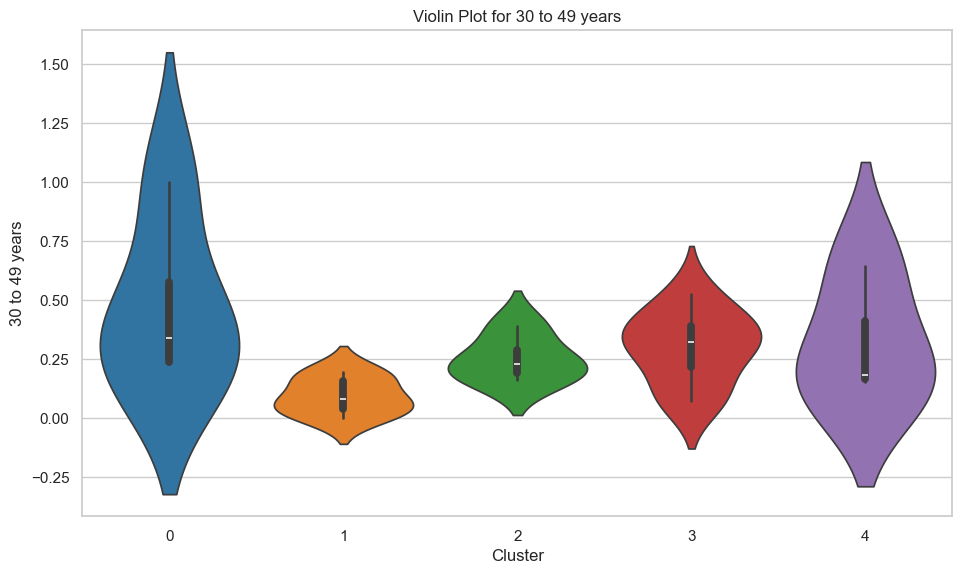

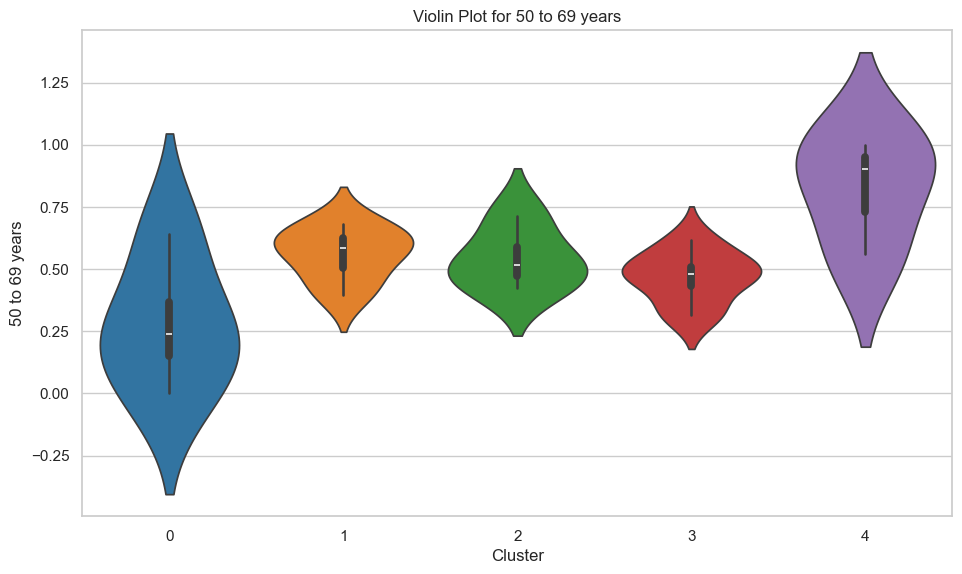

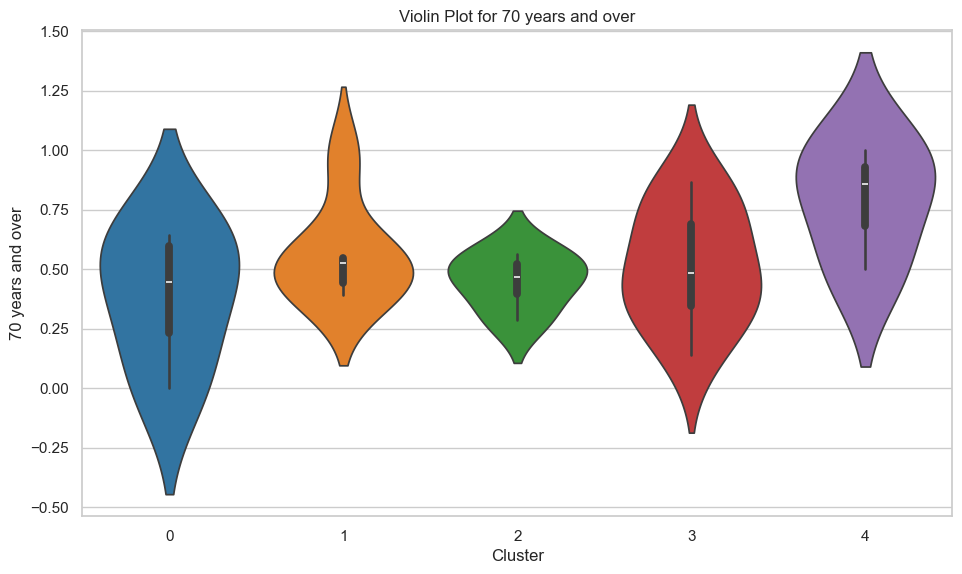

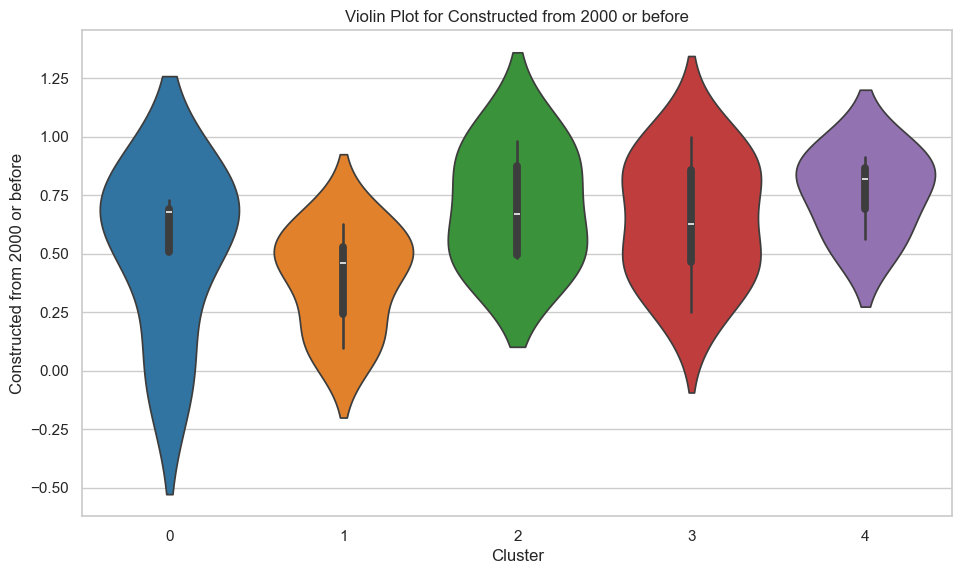

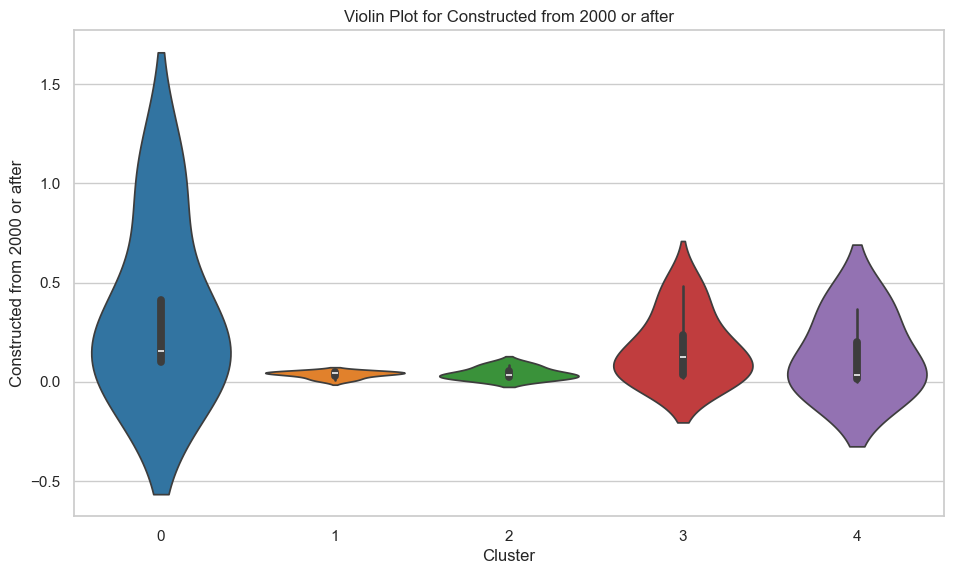

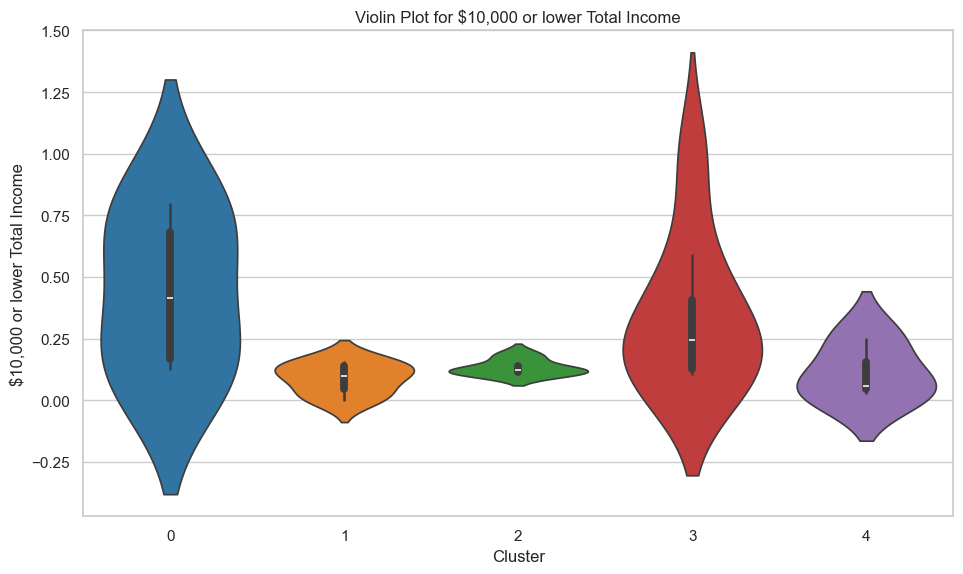

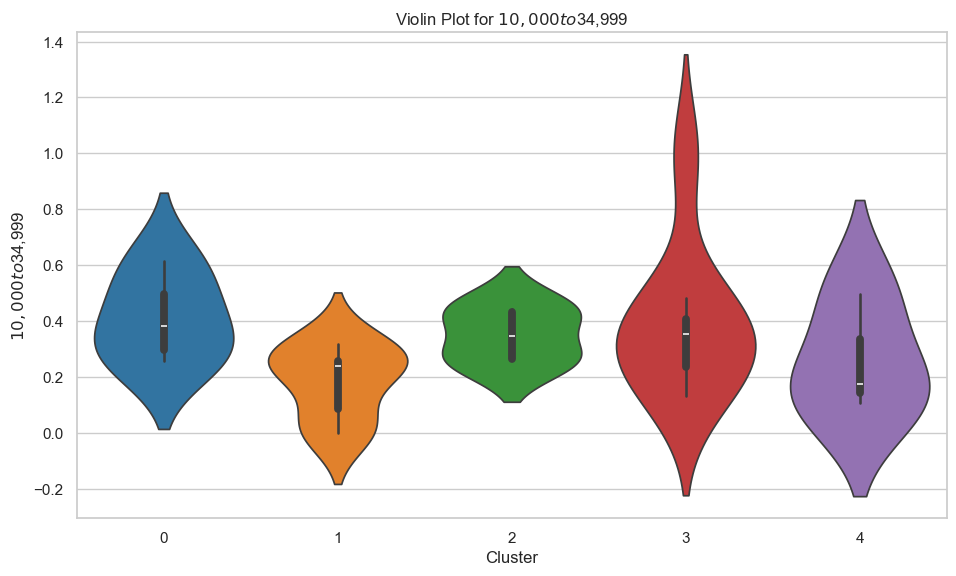

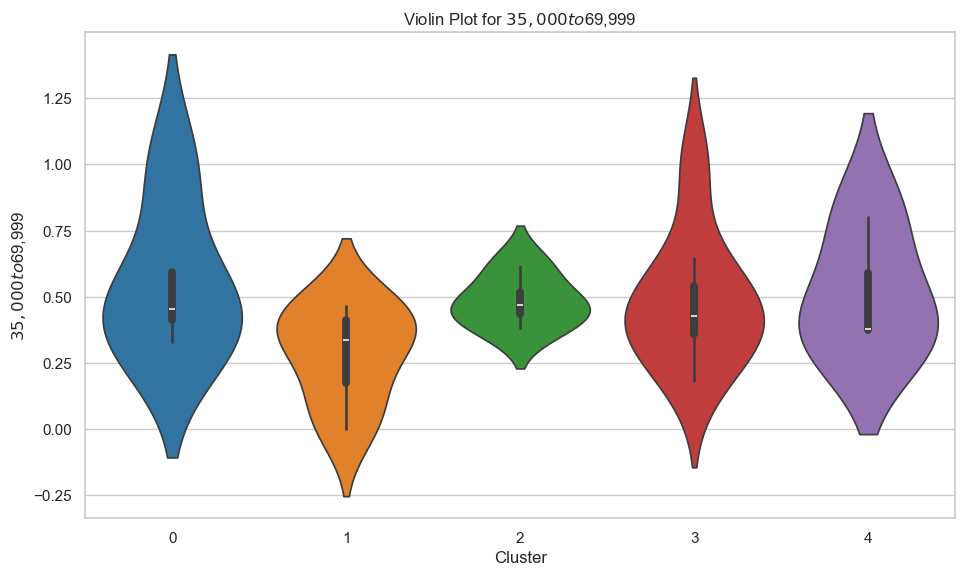

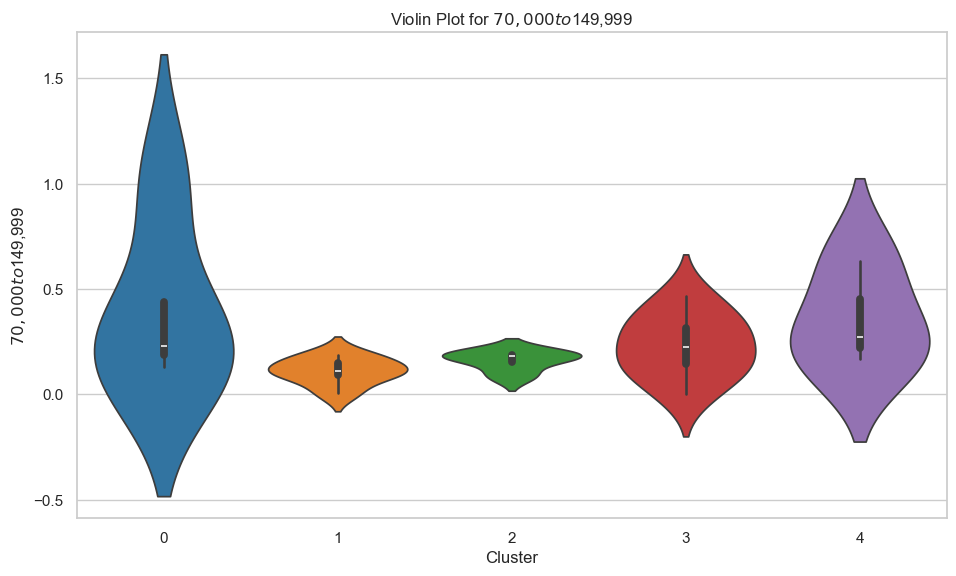

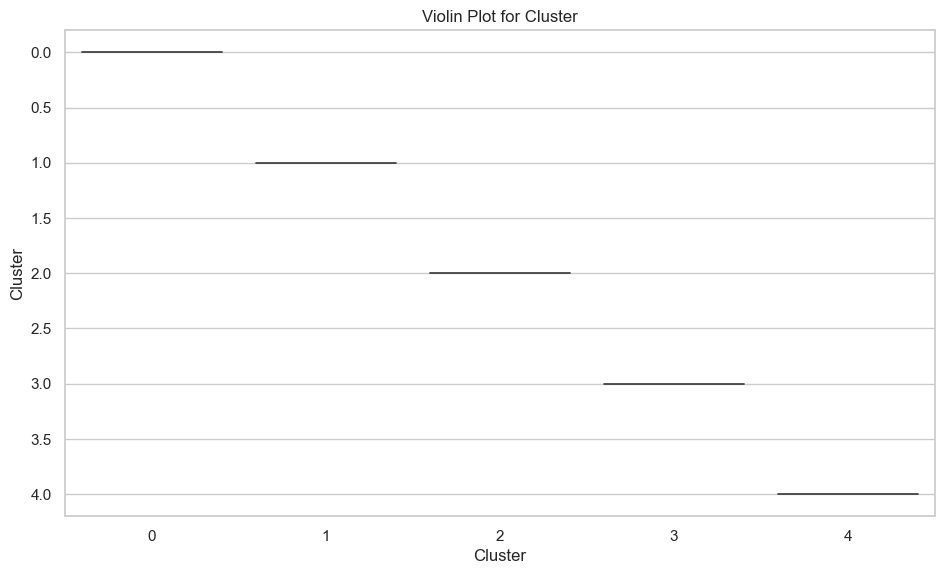

In [161]:
for column in tdemograph_data_clean_scaled.columns[:-1]:  # Exclude Cluster
    plt.figure(figsize=(10, 6))
    sns.violinplot(
        data=tdemograph_data_clean_scaled, 
        x='Cluster', 
        y=column, 
        palette='tab10'
    )
    plt.title(f'Violin Plot for {column}')
    plt.xlabel('Cluster')
    plt.ylabel(column)
    plt.show()

#labels for the salaries are scuffed!

In [162]:
tdemograph_data_clean_scaled.columns

Index(['Non-immigrants', 'Immigrants', 'Official languages',
       'Non-official languages', 'No certificate, diploma or degree',
       'High (secondary) school diploma or equivalency certificate',
       'Postsecondary certificate, diploma or degree', 'Employed',
       'Unemployed', 'Not in the labour force', '$200,000 and over',
       'Average total income of households in 2020 ($)',
       'Average monthly shelter costs for owned dwellings ($)',
       'Average total income in 2020 among recipients ($)',
       '% of owner households spending 30% or more of its income on shelter costs',
       '15 to 19 years', '20 to 29 years', '30 to 49 years', '50 to 69 years',
       '70 years and over', 'Constructed from 2000 or before',
       'Constructed from 2000 or after', '$10,000 or lower Total Income',
       '$10,000 to $34,999', '$35,000 to $69,999', '$70,000 to $149,999',
       'Cluster', 'Ward #'],
      dtype='object', name='Grouping')

In [163]:
tdemograph_data_clean_scaled['Ward #'] = range(1, 26)
tdemograph_data_clean_scaled['Ward #'].astype(int)
tdemograph_data_clean_scaled

Grouping  Non-immigrants  Immigrants  Official languages  \
0               0.288826    0.848265            0.460139   
1               0.731784    0.429052            0.666159   
2               1.000000    0.589202            1.000000   
3               0.795468    0.012558            0.807601   
4               0.468158    0.680735            0.566054   
5               0.291756    0.714915            0.339842   
6               0.235398    0.797126            0.398228   
7               0.714593    0.331693            0.774074   
8               0.625317    0.200155            0.586627   
9               0.811584    0.569524            0.937518   
10              0.598945    0.073537            0.672921   
11              0.749170    0.220482            0.860463   
12              0.533600    0.435396            0.649300   
13              0.813049    0.000000            0.816078   
14              0.524810    0.246116            0.535289   
15              0.210588    0.478379            0.275074   
16              0.102657    0.941611            0.143442   
17              0.122778    1.000000            0.135727   
18              0.827408    0.064863            0.898181   
19              0.518461    0.477861            0.612725   
20              0.287263    0.770456            0.380227   
21              0.053526    0.884257            0.075055   
22              0.000000    0.746375            0.000000   
23              0.257961    0.593604            0.413182   
24              0.324673    0.537157            0.537956   

Grouping  Non-official languages  No certificate, diploma or degree  \
0                       0.564417                           0.801413   
1                       0.436992                           0.334903   
2                       0.513924                           0.335688   
3                       0.036082                           0.154108   
4                       0.501463                           0.973574   
5                       0.564200                           0.426217   
6                       0.560299                           1.000000   
7                       0.259400                           0.287284   
8                       0.266118                           0.644165   
9                       0.450536                           0.000000   
10                      0.133167                           0.036107   
11                      0.159064                           0.087650   
12                      0.395492                           0.092883   
13                      0.029039                           0.310832   
14                      0.245855                           0.082679   
15                      0.356485                           0.267661   
16                      0.874309                           0.157771   
17                      1.000000                           0.068550   
18                      0.000000                           0.255887   
19                      0.313143                           0.467033   
20                      0.579694                           0.536368   
21                      0.792610                           0.535845   
22                      0.682197                           0.575615   
23                      0.371330                           0.430141   
24                      0.227544                           0.328100   

Grouping  High (secondary) school diploma or equivalency certificate  \
0                                                  0.983018            
1                                                  0.693555            
2                                                  0.723273            
3                                                  0.101505            
4                                                  1.000000            
5                                                  0.595137            
6                                                  0.983018            
7               

In [164]:
tdemograph_data_clean_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 28 columns):
 #   Column                                                                     Non-Null Count  Dtype   
---  ------                                                                     --------------  -----   
 0   Non-immigrants                                                             25 non-null     float64 
 1   Immigrants                                                                 25 non-null     float64 
 2   Official languages                                                         25 non-null     float64 
 3   Non-official languages                                                     25 non-null     float64 
 4   No certificate, diploma or degree                                          25 non-null     float64 
 5   High (secondary) school diploma or equivalency certificate                 25 non-null     float64 
 6   Postsecondary certificate, diploma or degree        

In [172]:
ward_collision['Ward #'] = ward_collision['Ward #'].astype(int)
ward_collision.info()
print(ward_collision['Ward #'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Ward #           25 non-null     int32  
 1   Ward Name        25 non-null     object 
 2   Bike Collisions  25 non-null     int64  
 3   Avg Latitude     25 non-null     float64
 4   Avg Longitude    25 non-null     float64
dtypes: float64(2), int32(1), int64(1), object(1)
memory usage: 1.0+ KB
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]


In [174]:
# #Adding collision data to the profiles
# ward_collision_merged = ward_collision.merge(
#     tdemograph_data_clean_scaled[['Cluster']], 
#     left_on ='Ward #', 
#     right_index = True, 
#     how = 'left')

# numcols = ward_collision_merged.select_dtypes(include='number')

# # Now group by 'Cluster' and calculate the mean of numeric columns
# cluster_profiles = numcols.groupby(ward_collision_merged['Cluster']).mean()

# cluster_profiles = ward_collision_merged.groupby('Cluster').mean()

In [176]:
# Merge the collision data with the demographic data, using 'Ward #' for merging
ward_collision_merged = ward_collision.merge(
    tdemograph_data_clean_scaled[['Cluster']], 
    left_on='Ward #', 
    right_index=True, 
    how='right'
)

# Drop the 'Ward #' column after the merge
ward_collision_merged = ward_collision_merged.drop(columns='Ward #')

# Display merged DataFrame
ward_collision_merged

Ward Name  Bike Collisions  Avg Latitude  Avg Longitude  \
NaN                        NaN              NaN           NaN            NaN   
0.0            Etobicoke North            216.0     43.727229     -79.583182   
1.0           Etobicoke Centre            217.0     43.667718     -79.550024   
2.0        Etobicoke-Lakeshore            376.0     43.620498     -79.514390   
3.0         Parkdale-High Park            550.0     43.650676     -79.458589   
4.0          York South-Weston            268.0     43.689563     -79.489267   
5.0                York Centre            242.0     43.751176     -79.473017   
6.0   Humber River-Black Creek            176.0     43.750481     -79.522831   
7.0          Eglinton-Lawrence            228.0     43.713493     -79.432990   
8.0                  Davenport            741.0     43.662404     -79.439988   
9.0          Spadina-Fort York           1587.0     43.645822     -79.397764   
10.0       University-Rosedale           1324.0     43.664261     -79.401827   
11.0        Toronto-St. Paul's            364.0     43.687308     -79.412727   
12.0            Toronto Centre           1132.0     43.658768     -79.374637   
13.0          Toronto-Danforth            716.0     43.671276     -79.342229   
14.0           Don Valley West            198.0     43.717832     -79.374766   
15.0           Don Valley East             96.0     43.733581     -79.335149   
16.0          Don Valley North            129.0     43.782411     -79.358126   
17.0                Willowdale            173.0     43.777330     -79.418684   
18.0         Beaches-East York            353.0     43.684734     -79.307466   
19.0     Scarborough Southwest            262.0     43.712957     -79.267564   
20.0        Scarborough Centre            277.0     43.749344     -79.280575   
21.0     Scarborough-Agincourt            242.0     43.798298     -79.307229   
22.0         Scarborough North            219.0     43.808651     -79.268227   
23.0     Scarborough-Guildwood            143.0     43.767247     -79.219518   

     Cluster  
NaN        4  
0.0        4  
1.0        4  
2.0        2  
3.0        2  
4.0        2  
5.0        2  
6.0        0  
7.0        0  
8.0        0  
9.0        0  
10.0       3  
11.0       3  
12.0       3  
13.0       3  
14.0       3  
15.0       3  
16.0       3  
17.0       3  
18.0       1  
19.0       1  
20.0       1  
21.0       1  
22.0       1  
23.0       1

In [178]:
#Then I select only the numeric columns
numcols = ward_collision_merged.select_dtypes(include='number')

# Now group by 'Cluster' and calculate the mean of numeric columns
cluster_profiles = numcols.groupby(ward_collision_merged['Cluster']).mean()

# Display the resulting profiles
print(cluster_profiles)

         Bike Collisions  Avg Latitude  Avg Longitude
Cluster                                              
0             683.000000     43.693050     -79.448393
1             249.333333     43.753538     -79.275097
2             359.000000     43.677978     -79.483816
3             516.500000     43.711596     -79.377268
4             216.500000     43.697473     -79.566603
